# Playground Series Season-3 Episode-3 Solution Notebook
## Classification with Employee Attrition Dataset
## Prepared by Dwaipayan Mukherjee (2211569)

### About the Project:

This project uses data synthetically generated by a deep learning model trained on the IBM HR Analytics Employee Attrition & Performance dataset.

The aim is to predict employee attrition (i.e., whether an employee will quit or not) based on 33 variables:
1. `Age`
2. `BusinessTravel`
3. `DailyRate`
4. `Department`
5. `DistanceFromHome`
6. `Education`
7. `EducationField`
8. `EmployeeCount`
9. `EnvironmentalSatisfaction`
10. `Gender`
11. `HourlyRate`
12. `JobInvolvement`
13. `JobLevel`
14. `JobRole`
15. `JobSatisfaction`
16. `MaritalStatus`
17. `MonthlyIncome`
18. `MonthlyRate`
19. `NumCompaniesWorked`
20. `Over18`
21. `OverTime`
22. `PercentSalaryHike`
23. `PerformanceRating`
24. `RelationshipSatisfaction`
25. `StrandardHours`
26. `StockOptionLevel`
27. `TotalWorkingYears`
28. `TrainingTimesLastYear`
29. `WorkLifeBalance
30. `YearsAtCompany`
31. `YearsInCurrentRole`
32. `YearsSinceLastPromotion`
33. `YearsWithCurrManager`

The `id` column is non-overlapping between `train` and `test` set, and is meant for data organization purposes. Thus, it likely carries no signal.

The target `Attrition` is a binary column.

The evaluation metric for this project has been selected to be the **area under the ROC curve** between the predicted probability and the observed target.

### Necessary Imports:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [47]:
from collections import OrderedDict
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc, RocCurveDisplay,roc_auc_score
import lightgbm as lgbm
import catboost
from sklearn.ensemble import RandomForestClassifier

In [3]:
import warnings
warnings.filterwarnings('ignore')

### Loading the train, test, original and sample_submissions data as Pandas DataFrames:

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')
original = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')

### Understanding the dataset:

First looking at the heads of the datasets:

In [5]:
train.head()

,id,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
0,0,36,Travel_Frequently,599,Research & Development,24,3,Medical,1,4,...,80,1,10,2,3,10,0,7,8,0
1,1,35,Travel_Rarely,921,Sales,8,3,Other,1,1,...,80,1,4,3,3,4,2,0,3,0
2,2,32,Travel_Rarely,718,Sales,26,3,Marketing,1,3,...,80,2,4,3,3,3,2,1,2,0
3,3,38,Travel_Rarely,1488,Research & Development,2,3,Medical,1,3,...,80,0,15,1,1,6,0,0,2,0
4,4,50,Travel_Rarely,1017,Research & Development,5,4,Medical,1,2,...,80,0,31,0,3,31,14,4,10,1


In [6]:
test.head()

,id,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,1677,19,Non-Travel,992,Research & Development,1,1,Medical,1,4,...,4,80,0,1,2,2,1,0,0,0
1,1678,45,Travel_Rarely,1136,Sales,4,4,Marketing,1,3,...,3,80,1,7,3,3,2,2,2,2
2,1679,37,Travel_Rarely,155,Research & Development,13,3,Life Sciences,1,4,...,2,80,2,13,2,2,7,7,1,7
3,1680,32,Travel_Rarely,688,Research & Development,1,4,Life Sciences,1,3,...,3,80,0,14,2,2,14,10,11,8
4,1681,29,Travel_Frequently,464,Research & Development,9,1,Life Sciences,1,3,...,1,80,0,1,5,3,1,0,0,0


In [7]:
original.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


**Looking for missing values:**

In [8]:
print('\n Missing Values in train set: \n')
print(train.isna().sum())

print('\n Missing Values in test set: \n')
print(test.isna().sum())

print('\n Missing Values in original set: \n')
print(original.isna().sum())


 Missing Values in train set: 

id                          0
Age                         0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSi

There are no missing values in any of the datasets.

**Descriptive Statistics of the datasets:**

In [9]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,1677.0,838.000000,484.252517,0.0,419.0,838.0,1257.0,1676.0
Age,1677.0,36.036971,8.507112,18.0,30.0,35.0,41.0,60.0
DailyRate,1677.0,892.749553,374.496259,107.0,589.0,890.0,1223.0,3921.0
DistanceFromHome,1677.0,8.683959,7.826143,1.0,2.0,7.0,12.0,29.0
Education,1677.0,2.937984,1.039078,1.0,2.0,3.0,4.0,15.0
EmployeeCount,1677.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
EnvironmentSatisfaction,1677.0,2.757901,1.086835,1.0,2.0,3.0,4.0,4.0
HourlyRate,1677.0,67.798450,19.435928,30.0,51.0,69.0,84.0,100.0
JobInvolvement,1677.0,2.782349,0.650664,1.0,2.0,3.0,3.0,4.0
JobLevel,1677.0,1.998807,1.083065,1.0,1.0,2.0,2.0,7.0


In [10]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
id,1119.0,2236.000000,323.171781,1677.0,1956.5,2236.0,2515.5,2795.0
Age,1119.0,36.147453,8.786102,18.0,30.0,35.0,41.0,59.0
DailyRate,1119.0,883.550492,366.427230,6.0,589.0,889.0,1206.0,1499.0
DistanceFromHome,1119.0,8.667560,7.772384,1.0,2.0,7.0,12.0,29.0
Education,1119.0,2.941912,1.012986,1.0,2.0,3.0,4.0,5.0
EmployeeCount,1119.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
EnvironmentSatisfaction,1119.0,2.736372,1.106668,0.0,2.0,3.0,4.0,4.0
HourlyRate,1119.0,68.226095,19.495282,30.0,52.0,71.0,85.0,100.0
JobInvolvement,1119.0,2.741734,0.652751,0.0,2.0,3.0,3.0,4.0
JobLevel,1119.0,1.999106,1.091109,1.0,1.0,2.0,2.0,5.0


In [11]:
original.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,1470.0,36.923810,9.135373,18.0,30.00,36.0,43.00,60.0
DailyRate,1470.0,802.485714,403.509100,102.0,465.00,802.0,1157.00,1499.0
DistanceFromHome,1470.0,9.192517,8.106864,1.0,2.00,7.0,14.00,29.0
Education,1470.0,2.912925,1.024165,1.0,2.00,3.0,4.00,5.0
EmployeeCount,1470.0,1.000000,0.000000,1.0,1.00,1.0,1.00,1.0
EmployeeNumber,1470.0,1024.865306,602.024335,1.0,491.25,1020.5,1555.75,2068.0
EnvironmentSatisfaction,1470.0,2.721769,1.093082,1.0,2.00,3.0,4.00,4.0
HourlyRate,1470.0,65.891156,20.329428,30.0,48.00,66.0,83.75,100.0
JobInvolvement,1470.0,2.729932,0.711561,1.0,2.00,3.0,3.00,4.0
JobLevel,1470.0,2.063946,1.106940,1.0,1.00,2.0,3.00,5.0


**Unique Values:**

In [12]:
print('Unique Value Counts')

print('\n---------train----------\n')
for i in train.columns:
    print(f'{i} : {train[i].nunique()}')

print('\n---------test----------\n')
for i in test.columns:
    print(f'{i} : {test[i].nunique()}')

print('\n---------original----------\n')
for i in original.columns:
    print(f'{i} : {original[i].nunique()}')

Unique Value Counts

---------train----------

id : 1677
Age : 43
BusinessTravel : 3
DailyRate : 625
Department : 3
DistanceFromHome : 29
Education : 6
EducationField : 6
EmployeeCount : 1
EnvironmentSatisfaction : 4
Gender : 2
HourlyRate : 71
JobInvolvement : 4
JobLevel : 6
JobRole : 9
JobSatisfaction : 4
MaritalStatus : 3
MonthlyIncome : 895
MonthlyRate : 903
NumCompaniesWorked : 10
Over18 : 1
OverTime : 2
PercentSalaryHike : 15
PerformanceRating : 2
RelationshipSatisfaction : 4
StandardHours : 1
StockOptionLevel : 4
TotalWorkingYears : 41
TrainingTimesLastYear : 7
WorkLifeBalance : 4
YearsAtCompany : 34
YearsInCurrentRole : 19
YearsSinceLastPromotion : 16
YearsWithCurrManager : 18
Attrition : 2

---------test----------

id : 1119
Age : 42
BusinessTravel : 3
DailyRate : 515
Department : 3
DistanceFromHome : 29
Education : 5
EducationField : 6
EmployeeCount : 1
EnvironmentSatisfaction : 5
Gender : 2
HourlyRate : 71
JobInvolvement : 5
JobLevel : 5
JobRole : 9
JobSatisfaction : 4
Marita

**Separating the categorical and continuous columns:**

In [13]:
cat_col = ['BusinessTravel', 'Department', 'Education', 'EducationField', 'EmployeeCount', 'EnvironmentSatisfaction', 'Gender', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'Over18', 'OverTime', 'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel', 'WorkLifeBalance', 'Attrition']
cont_col = [col for col in train.columns if col not in cat_col]

In [14]:
cont_col

['id',
 'Age',
 'DailyRate',
 'DistanceFromHome',
 'HourlyRate',
 'MonthlyIncome',
 'MonthlyRate',
 'NumCompaniesWorked',
 'PercentSalaryHike',
 'TotalWorkingYears',
 'TrainingTimesLastYear',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager']

Features distribution in the data:

No. of categorical features:  20
No. of continuous features:  15


([<matplotlib.patches.Wedge at 0x18e82f743a0>,
 [Text(-0.24477311341532162, 1.0724206837565984, 'Categorical features'),
  Text(0.24477321382259096, -1.072420660839281, 'Continuous features')],
 [Text(-0.13351260731744813, 0.5849567365945082, '57.1%'),
  Text(0.13351266208504958, -0.5849567240941532, '42.9%')])

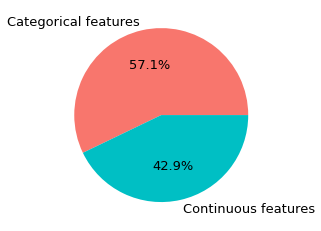

In [15]:
print('Features distribution in the data:\n')
print('No. of categorical features: ', len(cat_col))
print('No. of continuous features: ', len(cont_col))

plt.pie([len(cat_col), len(cont_col)],
        labels = ['Categorical features', 'Continuous features'],
        colors = ['#F8766D', '#00BFC4'],
        textprops = {'fontsize': 13},
        autopct = '%1.1f%%')

**Unique values of categorical variables:**

In [16]:
print("Unique Values of categorical variables")

print("\n--------train---------\n")
for i in cat_col:
    print(f'{i} : {train[i].unique()}')

print("\n--------test---------\n")
for i in ['BusinessTravel', 'Department', 'Education', 'EducationField', 'EmployeeCount', 'EnvironmentSatisfaction', 'Gender', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'Over18', 'OverTime', 'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel', 'WorkLifeBalance']:
    print(f'{i} : {test[i].unique()}')
    
print("\n--------original---------\n")
for i in cat_col:
    print(f'{i} : {original[i].unique()}')

Unique Values of categorical variables

--------train---------

BusinessTravel : ['Travel_Frequently' 'Travel_Rarely' 'Non-Travel']
Department : ['Research & Development' 'Sales' 'Human Resources']
Education : [ 3  4  1  2  5 15]
EducationField : ['Medical' 'Other' 'Marketing' 'Life Sciences' 'Technical Degree'
 'Human Resources']
EmployeeCount : [1]
EnvironmentSatisfaction : [4 1 3 2]
Gender : ['Male' 'Female']
JobInvolvement : [3 1 2 4]
JobLevel : [1 2 5 3 4 7]
JobRole : ['Laboratory Technician' 'Sales Representative' 'Sales Executive'
 'Healthcare Representative' 'Manager' 'Manufacturing Director'
 'Research Scientist' 'Human Resources' 'Research Director']
JobSatisfaction : [4 1 2 3]
MaritalStatus : ['Married' 'Divorced' 'Single']
Over18 : ['Y']
OverTime : ['Yes' 'No']
PerformanceRating : [3 4]
RelationshipSatisfaction : [2 4 3 1]
StandardHours : [80]
StockOptionLevel : [1 2 0 3]
WorkLifeBalance : [3 1 2 4]
Attrition : [0 1]

--------test---------

BusinessTravel : ['Non-Travel' 'T

**Distribution of target variable:**

In [17]:
train['Attrition'].value_counts()

0    1477
1     200
Name: Attrition, dtype: int64

### Exploratory Data Analysis:

**Distribution of target variable in train and original set:**

([<matplotlib.patches.Wedge at 0x18e83032790>,
 [Text(-0.9618916732177651, 0.5336332157899547, 'No'),
  Text(0.961891673217765, -0.5336332157899547, 'Yes')],
 [Text(-0.5246681853915082, 0.29107266315815705, '83.9%'),
  Text(0.5246681853915082, -0.2910726631581571, '16.1%')])

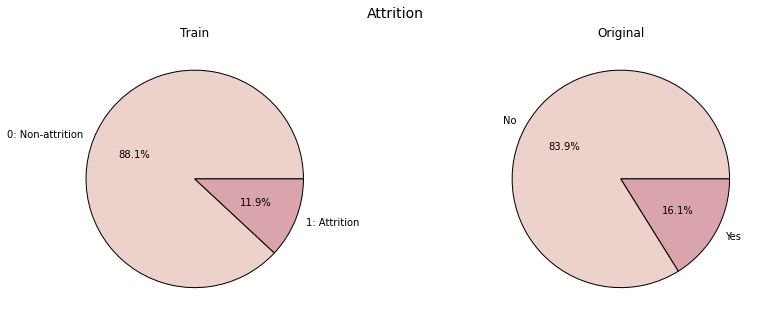

In [18]:
# color
colors = sns.cubehelix_palette()

# figure, axes
fig, ax = plt.subplots(1, 2, figsize=(14,5))
# figure title
fig.suptitle('Attrition', fontsize=14)

# train / original Stroke differences
ax[0].set_title('Train')
ax[1].set_title('Original')
plot_data_train = train['Attrition'].value_counts()
plot_data_original = original['Attrition'].value_counts()
plot_labels_train = plot_data_train.rename(index={0:'0: Non-attrition', 1:'1: Attrition'}).index
plot_labels_original = plot_data_original.rename(index={0:'0: Non-attrition', 1:'1: Attrition'}).index
ax[0].pie(plot_data_train, labels=plot_labels_train, autopct='%1.1f%%', colors=colors, wedgeprops = dict(edgecolor='black'))
ax[1].pie(plot_data_original, labels=plot_labels_original, autopct='%1.1f%%', colors=colors, wedgeprops = dict(edgecolor='black'))


The rate of attrition in the original dataset is 16% and that in train data is nearly 12%. So, the train data is more or less representative of the original dataset.

Moreover, I find that the dataset is highly imbalanced. To take care of this imbalance in the data, I will use Stratified K-fold CV while applying any model on the training data.

**Categorical Variables: Distribution in the datasets and the likelihood of attrition**

In [19]:
cat_col

['BusinessTravel',
 'Department',
 'Education',
 'EducationField',
 'EmployeeCount',
 'EnvironmentSatisfaction',
 'Gender',
 'JobInvolvement',
 'JobLevel',
 'JobRole',
 'JobSatisfaction',
 'MaritalStatus',
 'Over18',
 'OverTime',
 'PerformanceRating',
 'RelationshipSatisfaction',
 'StandardHours',
 'StockOptionLevel',
 'WorkLifeBalance',
 'Attrition']

We need to remove the target variable `Attrition` from this list.

In [20]:
cat_col.remove('Attrition')
cat_col

['BusinessTravel',
 'Department',
 'Education',
 'EducationField',
 'EmployeeCount',
 'EnvironmentSatisfaction',
 'Gender',
 'JobInvolvement',
 'JobLevel',
 'JobRole',
 'JobSatisfaction',
 'MaritalStatus',
 'Over18',
 'OverTime',
 'PerformanceRating',
 'RelationshipSatisfaction',
 'StandardHours',
 'StockOptionLevel',
 'WorkLifeBalance']

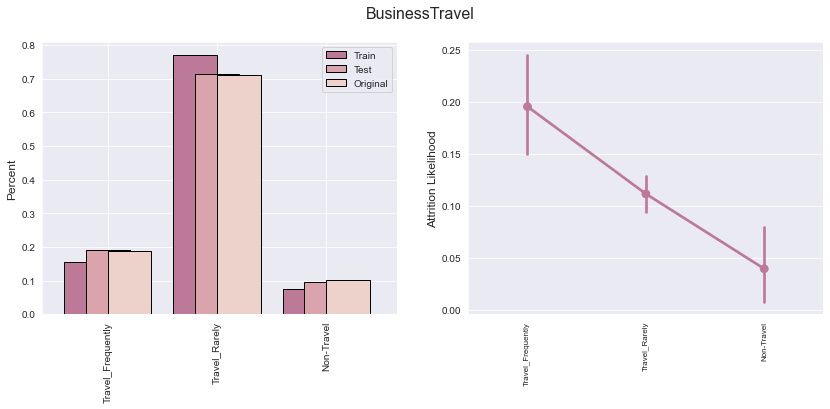

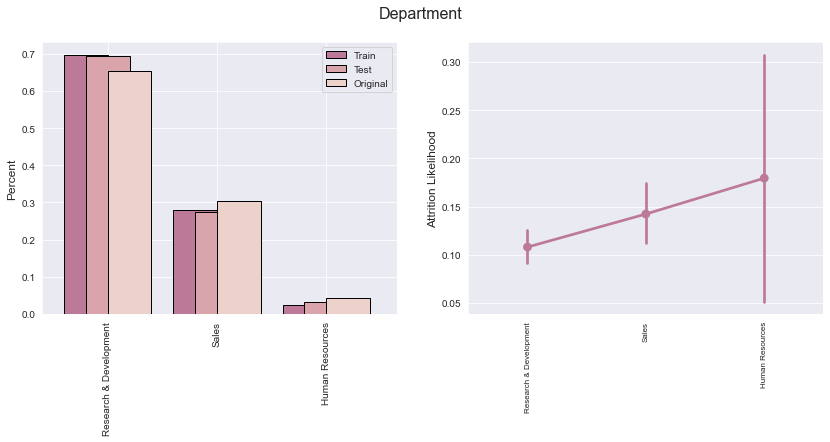

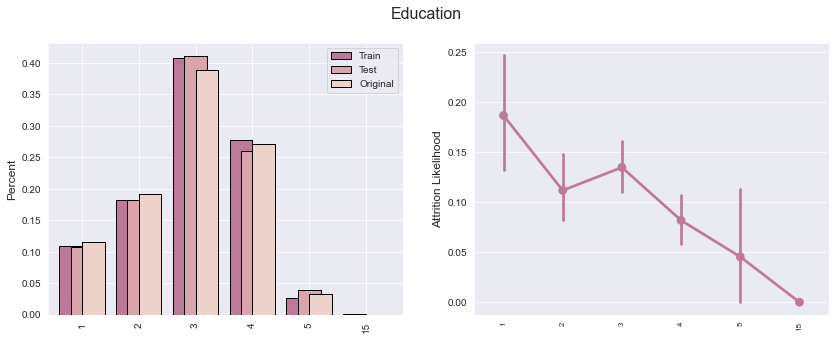

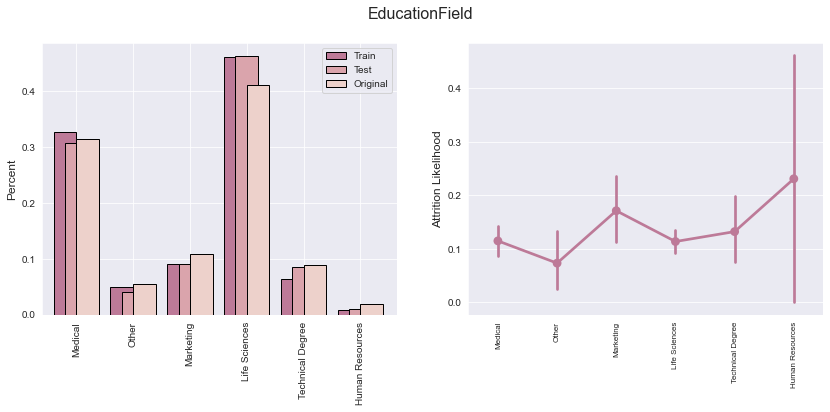

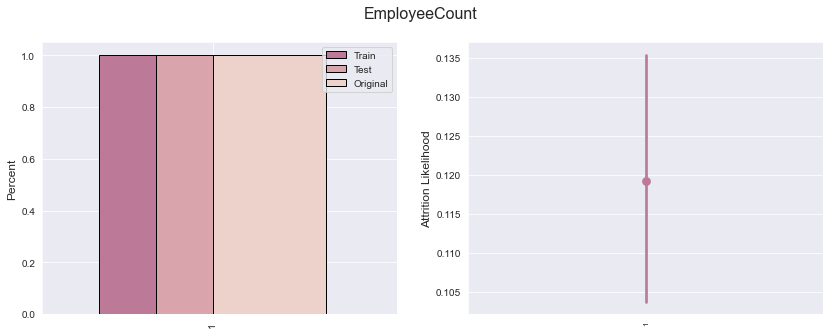

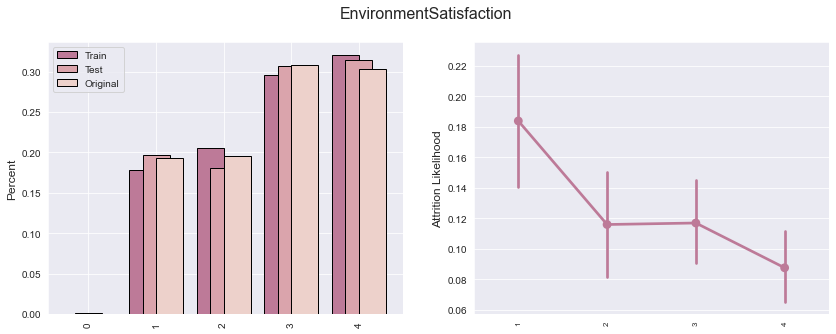

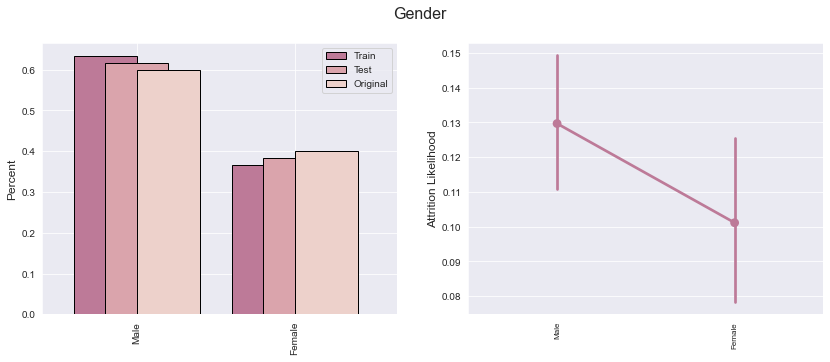

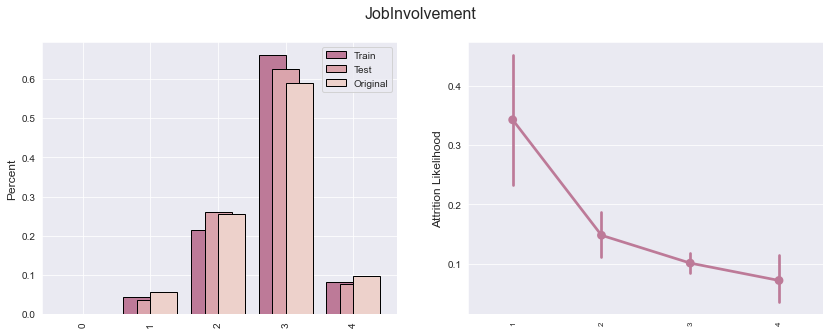

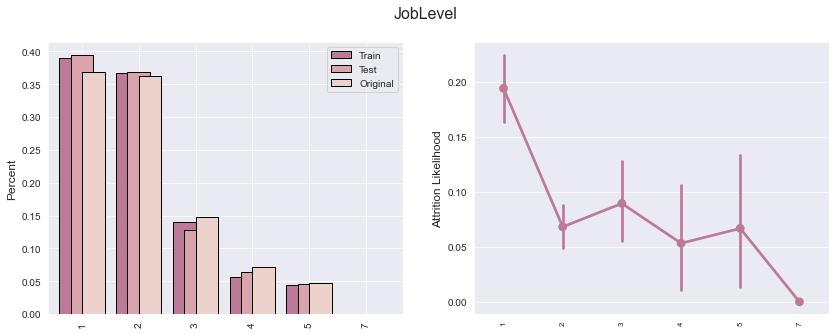

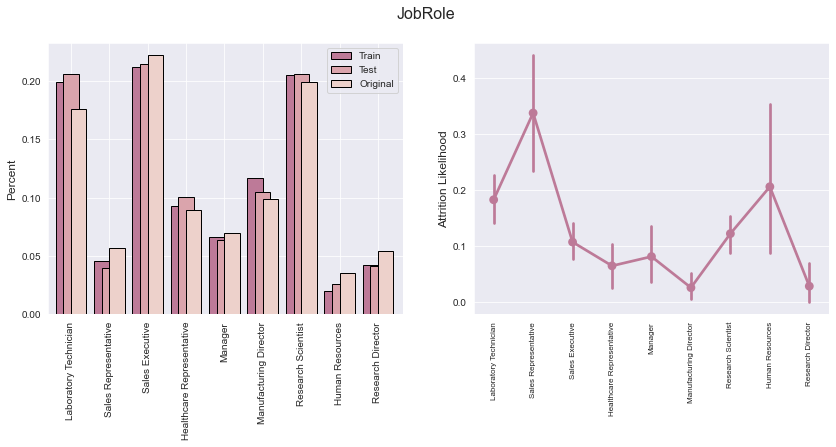

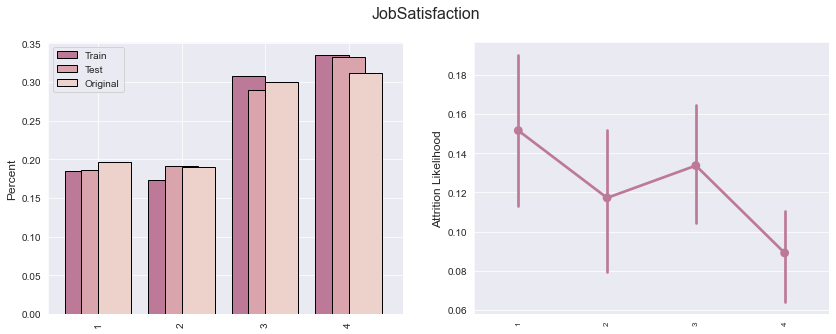

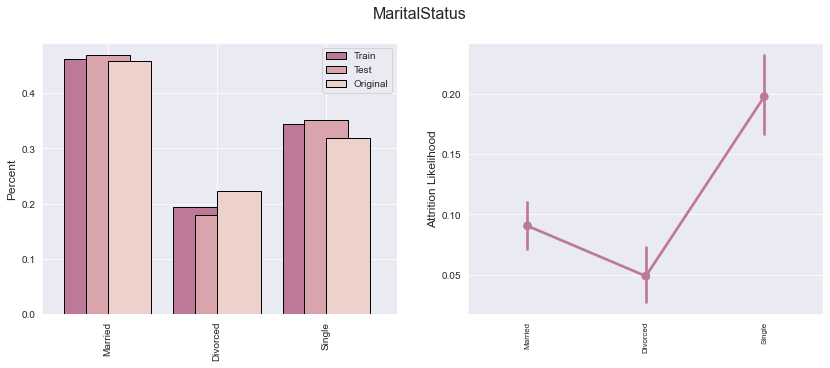

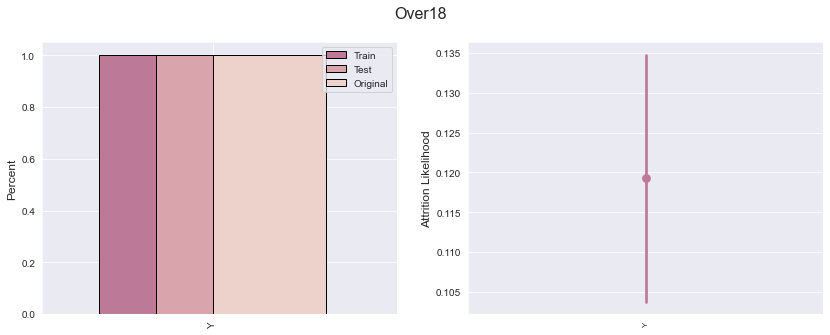

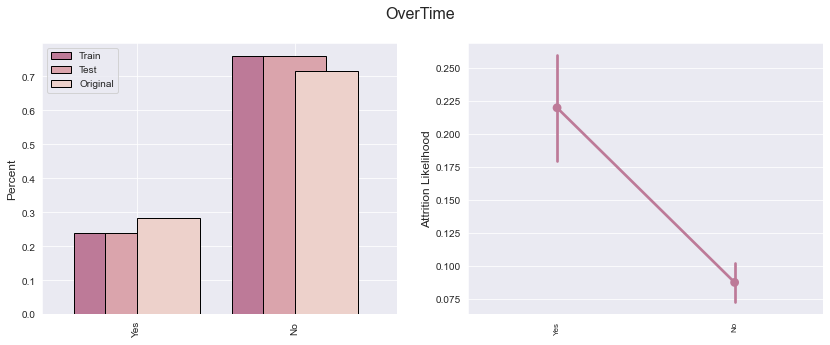

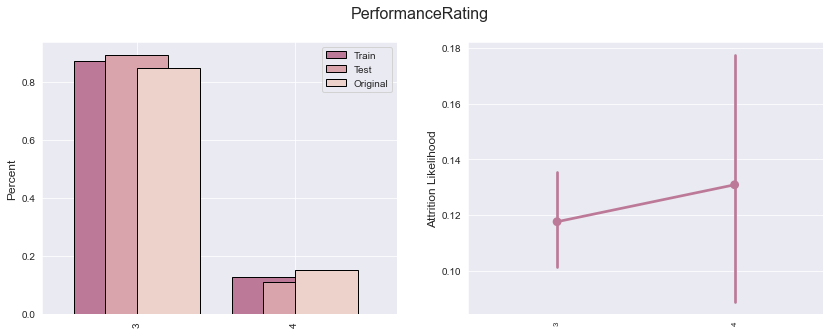

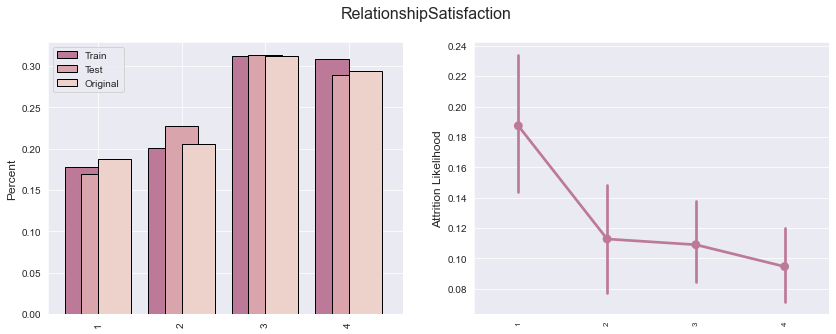

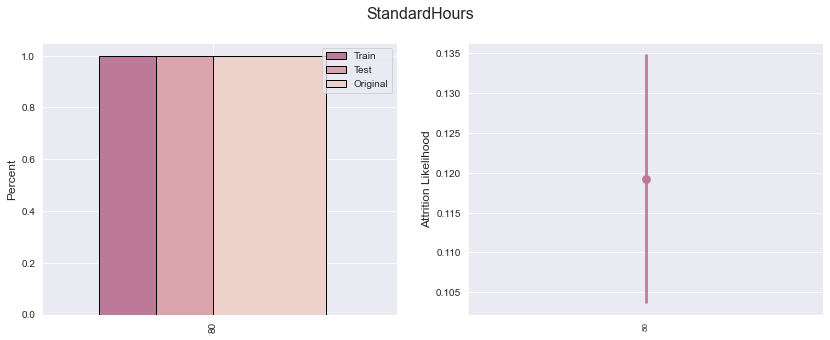

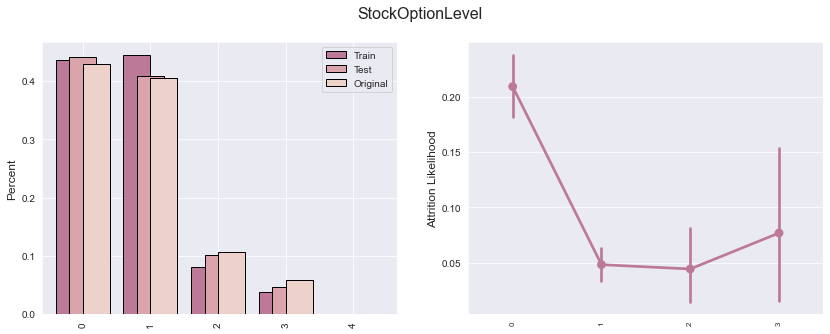

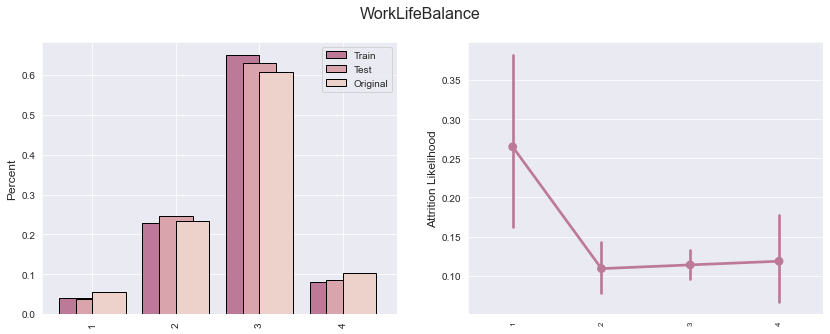

In [21]:
for i in cat_col:
    
    ## xticks:
    xticks_train = list(train[i].unique())
    xticks_test = list(test[i].unique())
    xticks_original = list(original[i].unique())
    
    ## merging xticks_train, xticks_test and xticks_original
    xticks = list(OrderedDict.fromkeys(xticks_train + xticks_test + xticks_original))
    if all([str(item).isdigit() for item in xticks]): xticks.sort()
        
    # figure, axes
    sns.set_style('darkgrid')
    fig, ax = plt.subplots(1, 2, figsize=(14,5))
    # figure title
    fig.suptitle(i, fontsize=16)
    
    ## train / test / original differences:
    pct_train = train[i].value_counts(normalize=True).reindex(xticks)
    pct_test = test[i].value_counts(normalize=True).reindex(xticks)
    pct_original = original[i].value_counts(normalize=True).reindex(xticks)
    
    pct_train.plot(kind = 'bar',
                   align = 'edge',
                   width = -0.4,
                   ax = ax[0],
                   color = colors[2],
                   edgecolor = 'black')
    pct_test.plot(kind = 'bar',
                  align = 'center',
                  width = 0.4,
                  ax = ax[0],
                  color = colors[1],
                  edgecolor = 'black')
    pct_original.plot(kind = 'bar',
                      align = 'edge',
                      width = 0.4,
                      ax = ax[0],
                      color = colors[0],
                      edgecolor = 'black')
    ax[0].set_xlim(-0.6)
    ax[0].set_ylabel('Percent', fontsize=12)
    ax[0].legend(['Train', 'Test', 'Original'])
    
    ## Attrition Likelihood:
    sns.pointplot(data = train,
                  x = i,
                  y = 'Attrition',
                  color = colors[2],
                  ax = ax[1])
    ax[1].tick_params(axis='x', labelsize=8, rotation=90)
    ax[1].set_xlabel('')
    ax[1].set_ylabel('Attrition Likelihood', fontsize=12)
    
    
    

A major inference from this EDA is that all the categorical variables except three, namely, `EmployeeCount`, `Over18` and `StandardHours` influences the likelihood of attrition. Thus, these three variables provide no signal and hence can be dropped.

Furthermore, some of the classes of some categorical variables show high likelihood of attrition but high variance as well since there are only a few observations pertaining to that particular class.

Some categorical variables like `BusinessTravel`, `Education`, `EnvironmentSatisfaction`, `Gender`, `JobInvolvement`, `MaritalStatus` and `OverTime` shows marked variance in likelihood of attrition across their classes and so, these variables might be mighty important in determining the attrition probability of an employee.

**Continuous Variables: Distribution in the datasets and distribution of Attrition w.r.t them:**

In [22]:
cont_col.remove('id')
cont_col

['Age',
 'DailyRate',
 'DistanceFromHome',
 'HourlyRate',
 'MonthlyIncome',
 'MonthlyRate',
 'NumCompaniesWorked',
 'PercentSalaryHike',
 'TotalWorkingYears',
 'TrainingTimesLastYear',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager']

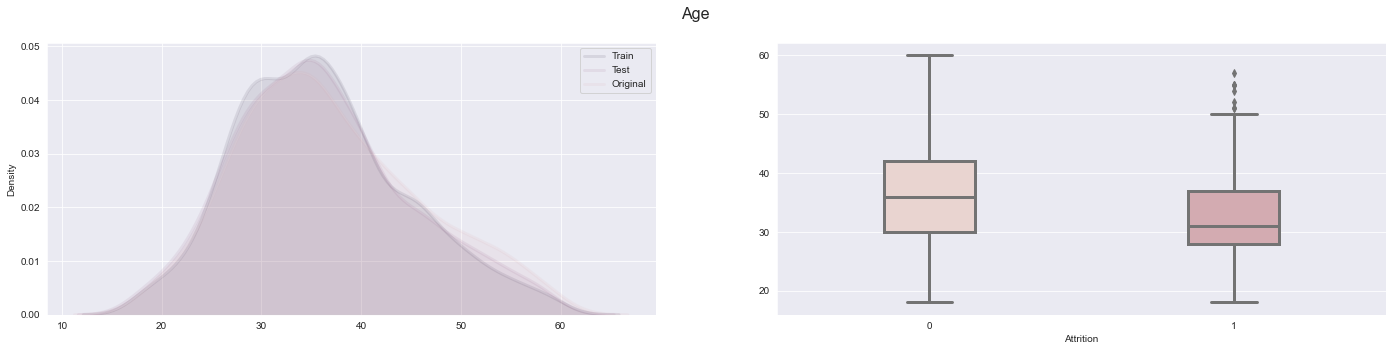

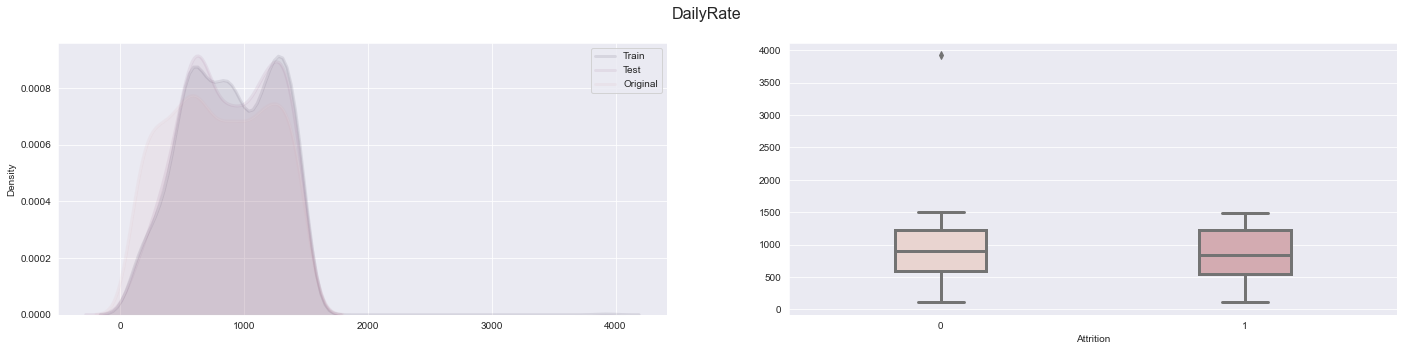

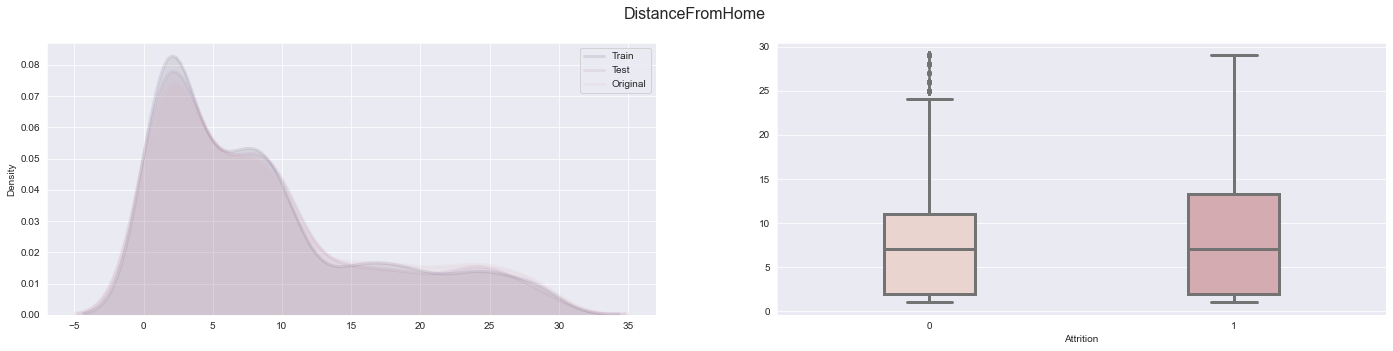

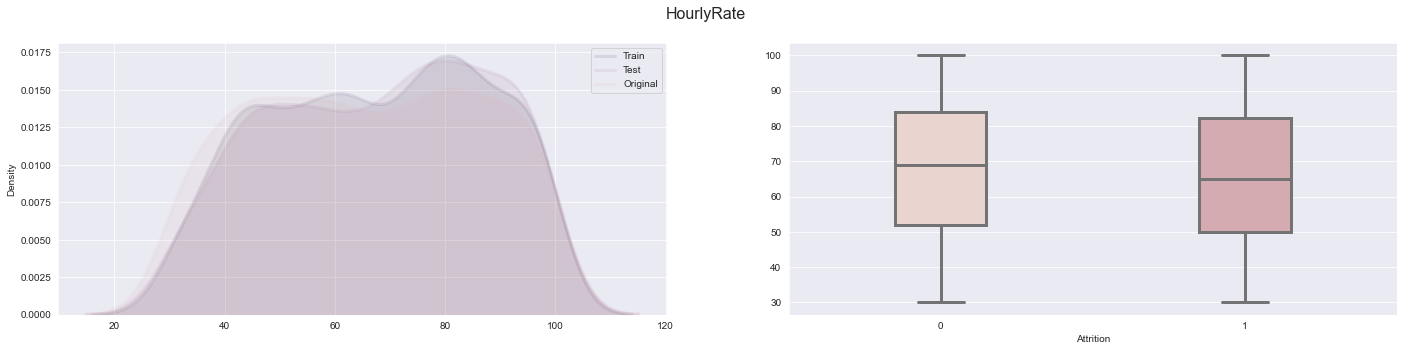

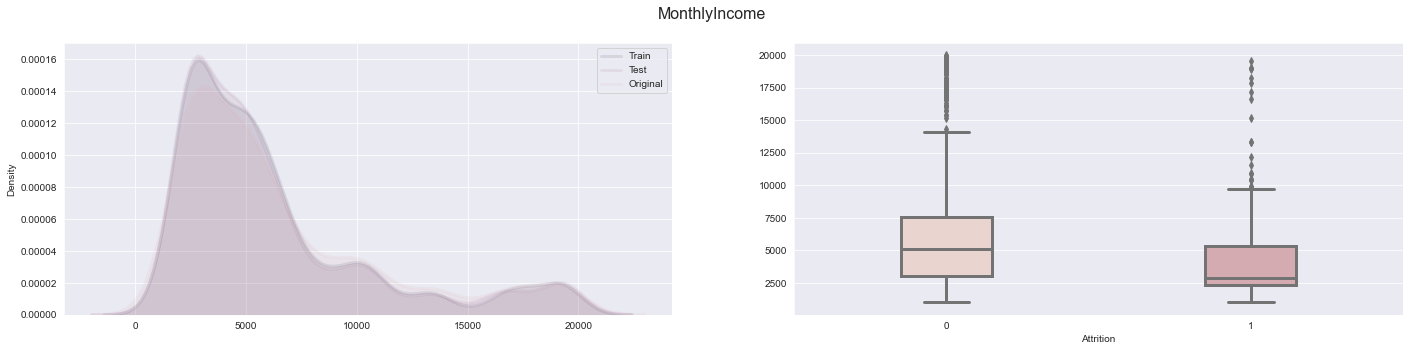

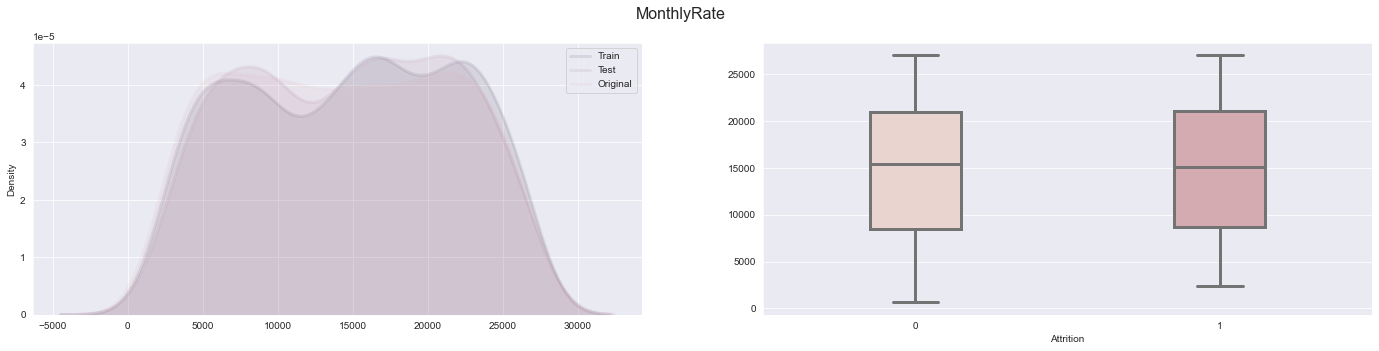

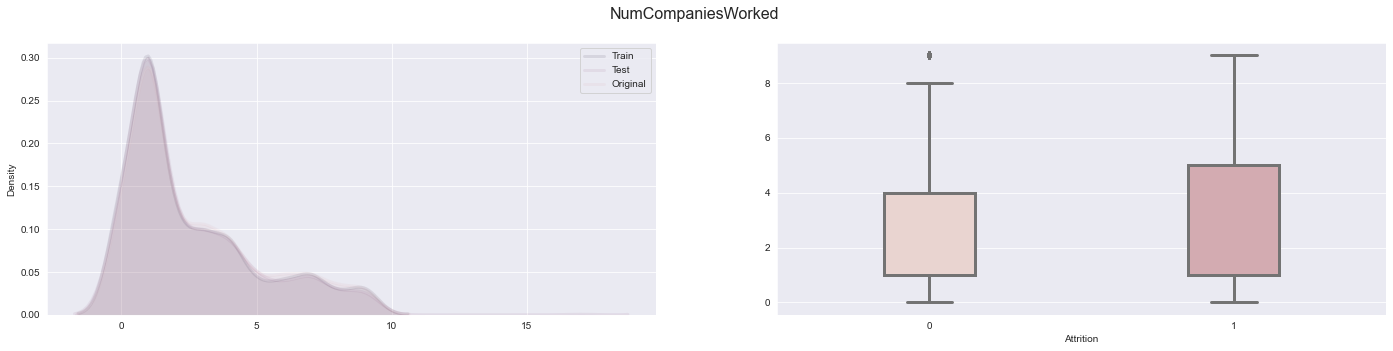

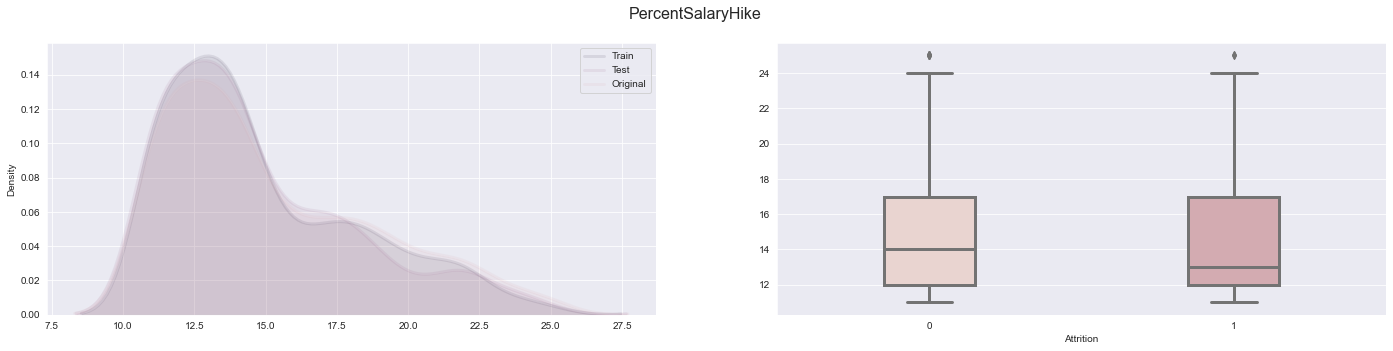

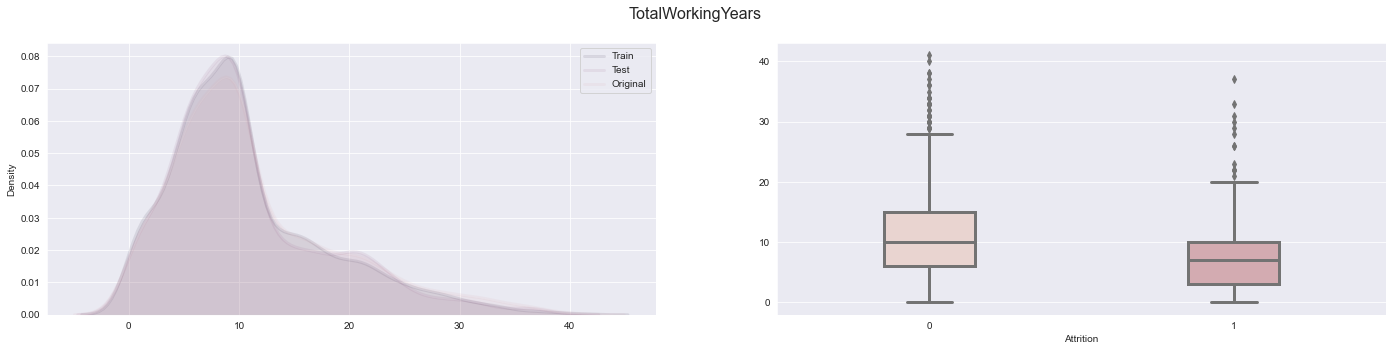

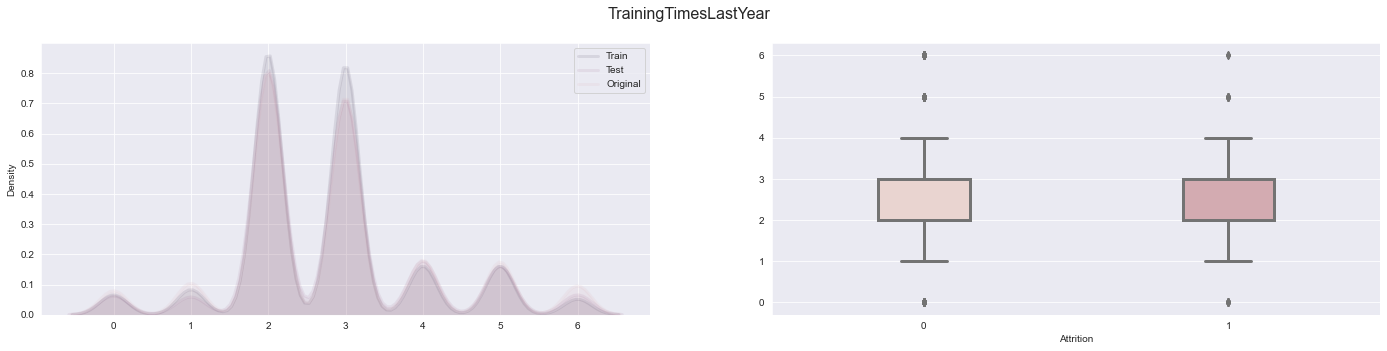

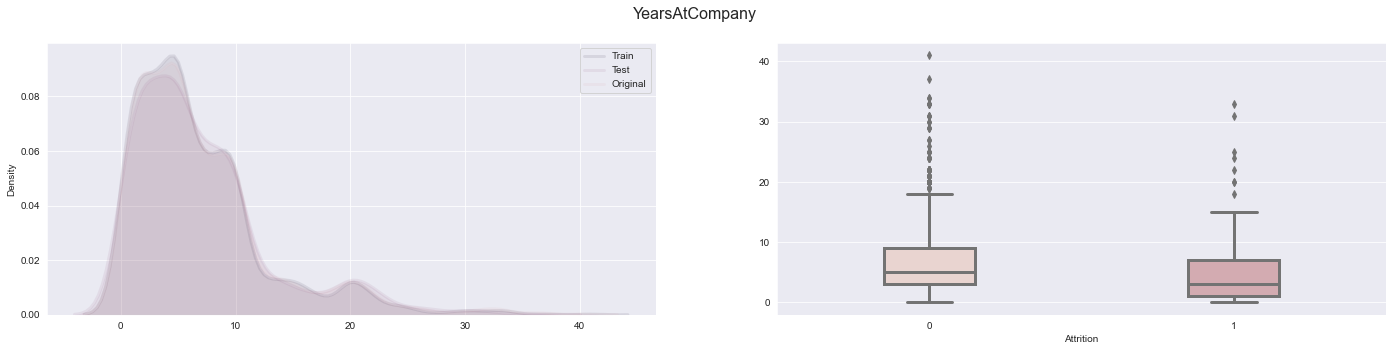

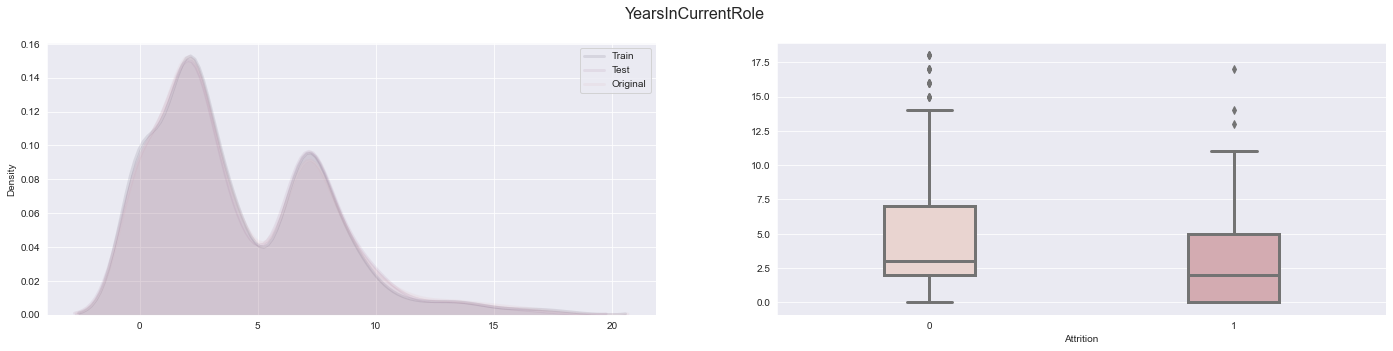

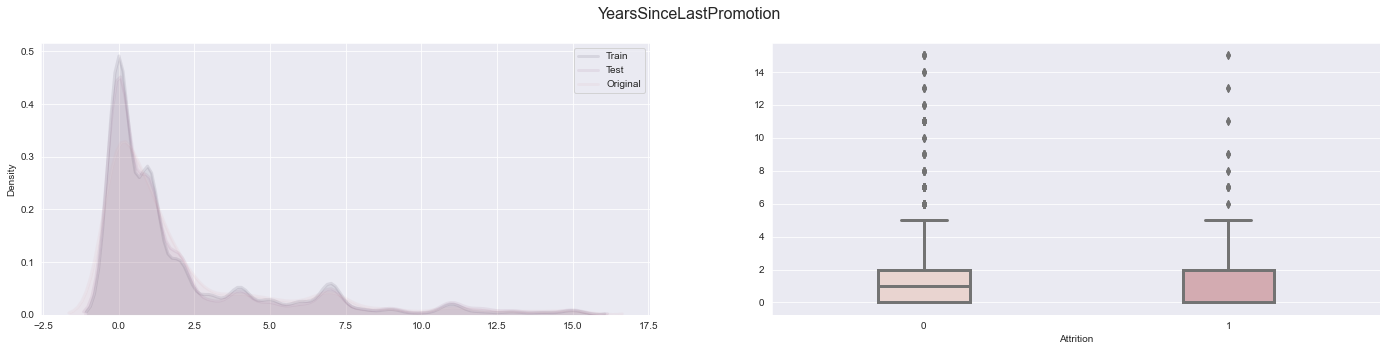

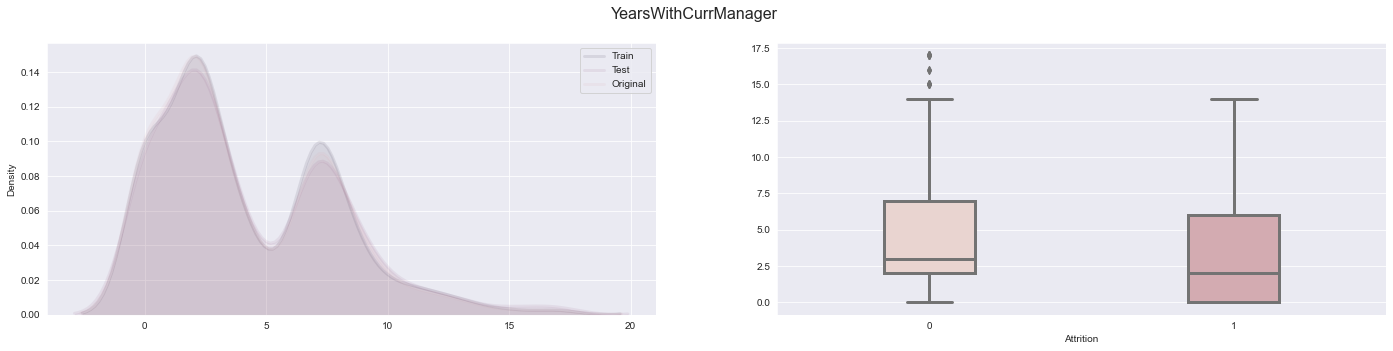

In [23]:
for i in cont_col:
    
    # figure, axes
    sns.set_style('darkgrid')
    fig, ax = plt.subplots(1, 2, figsize=(24,5))
    # figure title
    fig.suptitle(i, fontsize=16)

    # train / test / original differences
    sns.kdeplot(train[i], shade=True, color=colors[5], ax=ax[0], label='Train', alpha=0.1, linewidth=3)
    sns.kdeplot(test[i], shade=True, color=colors[3], ax=ax[0], label='Test', alpha=0.1, linewidth=3)
    sns.kdeplot(original[i], shade=True, color=colors[1], ax=ax[0], label='Original', alpha=0.1, linewidth=3)
    ax[0].set_xlabel('')
    ax[0].set_ylabel('Density')
    handles, labels = ax[0].get_legend_handles_labels()
    ax[0].legend(handles, labels)
    

    
    # boxplot
    sns.boxplot(y=i, x='Attrition', data=train, width=0.3, ax=ax[1], palette=colors, linewidth=3)
    ax[1].set_xlabel('Attrition')
    ax[1].set_ylabel('')

The inferences that can be drawn from this EDA is firstly that the distribution of the continuous variables in the train and test data follow the distribution of the same variables in the original dataset.

Next, none of the continuous variables show much difference in distribution with respect to the attrition variable. Feature engineering might bring about discernable patterns in the distributions with respect to attrition.

### Feature Engineering:

The following new features are created:

    1. `MonthlyIncome/Age`: a continuous variable measuring the monthly income over age.
    
    2. `Age_risk`: a binary variable which is 1 if age is less than 34. There is supposed to be a difference in the likelihood of attrition between younger and older folks.
    
    3. `HourlyRate_risk`: a binary variable which is 1 if hourly rate is less than 60. An hourly rate less than 60 may be a sufficient reason for employees to leave.
    
    4. `Distance_risk`: a binary variable which is 1 if distance from home is greater than or equal to 20. A distance of greater than 20 miles between home and office may be a reasonable reason for employees to leave and seek employement somewhere nearer.
    
    5. `YearsAtCo_risk`: a binary variable which is 1 if years in company is less than 4 years. An employee who is a new-comer to a company might be more likely to leave than an experienced veteran of the company.
    
    6. `AverageTenure`: a continuous variable obtained from dividing total working years by the number of companies worked.
    
    7. `JobHopper`: a binary variable which is 1 if an employee has worked in more than 2 companies and if his/her average tenure in a company has been less than 2 years. It is a reasonable assumption to think such a person might change jobs frequently.
    
    8. `Attrition_risk`: a combined risk measure made of `Age_risk`, `HourlyRate_risk`, `Distance_risk`, `YearsAtCo_risk` and `JobHopper`.

I have created a function called `feature_eng()` to apply the following feature engineering onto the `train` and the `test` set.

In [24]:
def feature_eng(df):
    df['MonthlyIncome/Age'] = df['MonthlyIncome'] / df['Age']
    df["Age_risk"] = (df["Age"] < 34).astype(int)
    df["HourlyRate_risk"] = (df["HourlyRate"] < 60).astype(int)
    df["Distance_risk"] = (df["DistanceFromHome"] >= 20).astype(int)
    df["YearsAtCo_risk"] = (df["YearsAtCompany"] < 4).astype(int)
    
    df['NumCompaniesWorked'] = df['NumCompaniesWorked'].replace(0, 1)
    df['AverageTenure'] = df["TotalWorkingYears"] / df["NumCompaniesWorked"]
    
    df['JobHopper'] = ((df["NumCompaniesWorked"] > 2) & (df["AverageTenure"] < 2.0)).astype(int)
    df["AttritionRisk"] = df["Age_risk"] + df["HourlyRate_risk"] + df["Distance_risk"] + df["YearsAtCo_risk"] + df['JobHopper']

In [25]:
feature_eng(train)

In [26]:
train.head()

,id,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,...,YearsWithCurrManager,Attrition,MonthlyIncome/Age,Age_risk,HourlyRate_risk,Distance_risk,YearsAtCo_risk,AverageTenure,JobHopper,AttritionRisk
0,0,36,Travel_Frequently,599,Research & Development,24,3,Medical,1,4,...,8,0,72.111111,0,1,1,0,10.0,0,2
1,1,35,Travel_Rarely,921,Sales,8,3,Other,1,1,...,3,0,82.828571,0,1,0,0,4.0,0,1
2,2,32,Travel_Rarely,718,Sales,26,3,Marketing,1,3,...,2,0,144.593750,1,0,1,1,4.0,0,3
3,3,38,Travel_Rarely,1488,Research & Development,2,3,Medical,1,3,...,2,0,140.710526,0,1,0,0,5.0,0,1
4,4,50,Travel_Rarely,1017,Research & Development,5,4,Medical,1,2,...,10,1,380.660000,0,1,0,0,31.0,0,1


In [27]:
feature_eng(test)
test.head()

,id,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,...,YearsSinceLastPromotion,YearsWithCurrManager,MonthlyIncome/Age,Age_risk,HourlyRate_risk,Distance_risk,YearsAtCo_risk,AverageTenure,JobHopper,AttritionRisk
0,1677,19,Non-Travel,992,Research & Development,1,1,Medical,1,4,...,0,0,122.000000,1,1,0,1,1.000000,0,3
1,1678,45,Travel_Rarely,1136,Sales,4,4,Marketing,1,3,...,2,2,121.911111,0,0,0,1,1.166667,1,2
2,1679,37,Travel_Rarely,155,Research & Development,13,3,Life Sciences,1,4,...,1,7,74.081081,0,1,0,0,3.250000,0,1
3,1680,32,Travel_Rarely,688,Research & Development,1,4,Life Sciences,1,3,...,11,8,163.375000,1,0,0,0,14.000000,0,1
4,1681,29,Travel_Frequently,464,Research & Development,9,1,Life Sciences,1,3,...,0,0,42.172414,1,0,0,1,1.000000,0,2


Now I check if these new features can explain variation in likelihood of attrition better than the actual variables or not.

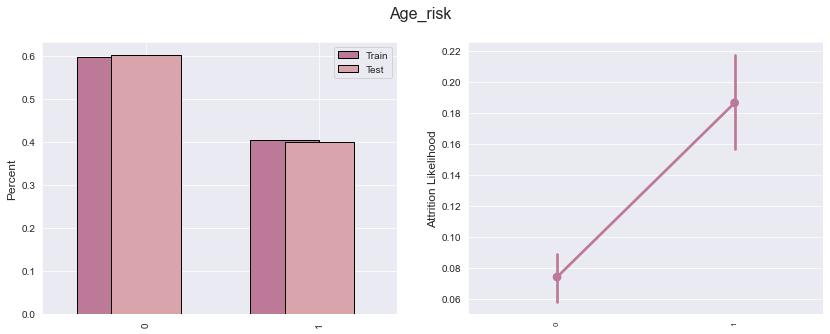

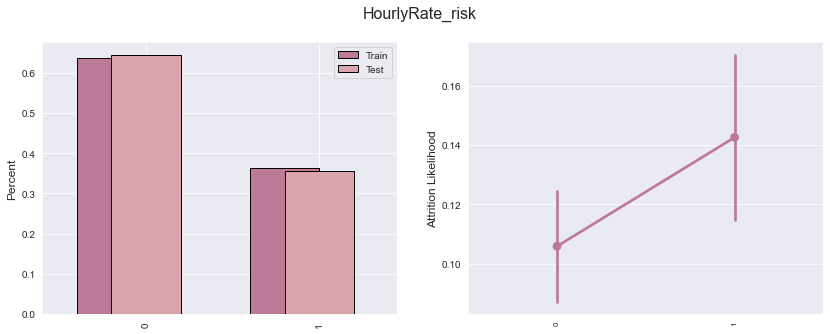

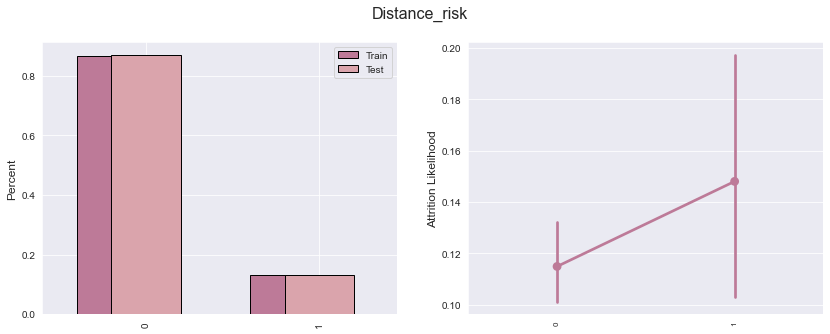

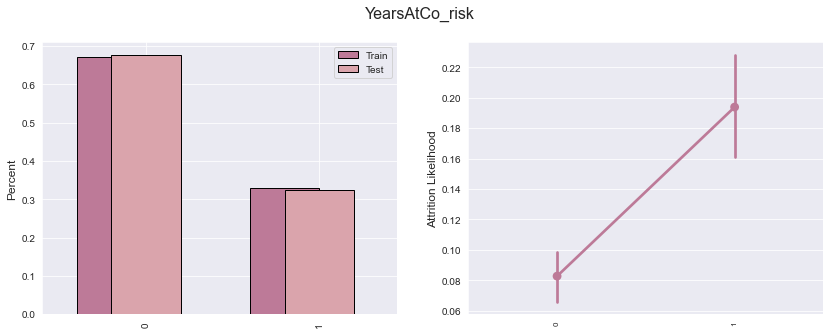

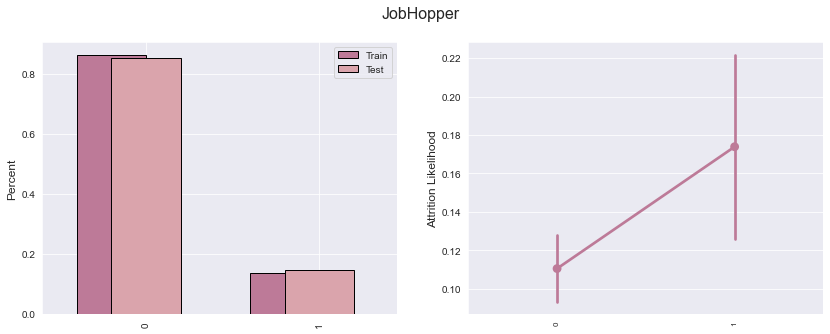

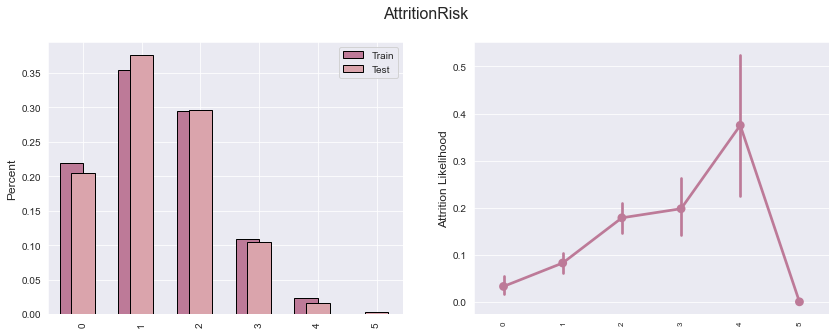

In [28]:
cols = ['Age_risk', 'HourlyRate_risk', 'Distance_risk', 'YearsAtCo_risk', 'JobHopper', 'AttritionRisk']
for i in cols:
    
    ## xticks:
    xticks_train = list(train[i].unique())
    xticks_test = list(test[i].unique())
        
    ## merging xticks_train, xticks_test 
    xticks = list(OrderedDict.fromkeys(xticks_train + xticks_test))
    if all([str(item).isdigit() for item in xticks]): xticks.sort()
        
    # figure, axes
    sns.set_style('darkgrid')
    fig, ax = plt.subplots(1, 2, figsize=(14,5))
    # figure title
    fig.suptitle(i, fontsize=16)
    
    ## train / test / original differences:
    pct_train = train[i].value_counts(normalize=True).reindex(xticks)
    pct_test = test[i].value_counts(normalize=True).reindex(xticks)
    
    
    pct_train.plot(kind = 'bar',
                   align = 'edge',
                   width = -0.4,
                   ax = ax[0],
                   color = colors[2],
                   edgecolor = 'black')
    pct_test.plot(kind = 'bar',
                  align = 'center',
                  width = 0.4,
                  ax = ax[0],
                  color = colors[1],
                  edgecolor = 'black')
   
    ax[0].set_xlim(-0.6)
    ax[0].set_ylabel('Percent', fontsize=12)
    ax[0].legend(['Train', 'Test'])
    
    ## Attrition Likelihood:
    sns.pointplot(data = train,
                  x = i,
                  y = 'Attrition',
                  color = colors[2],
                  ax = ax[1])
    ax[1].tick_params(axis='x', labelsize=8, rotation=90)
    ax[1].set_xlabel('')
    ax[1].set_ylabel('Attrition Likelihood', fontsize=12)

The patterns are much more discernable and follow the initial assumptions on which they were engineered.

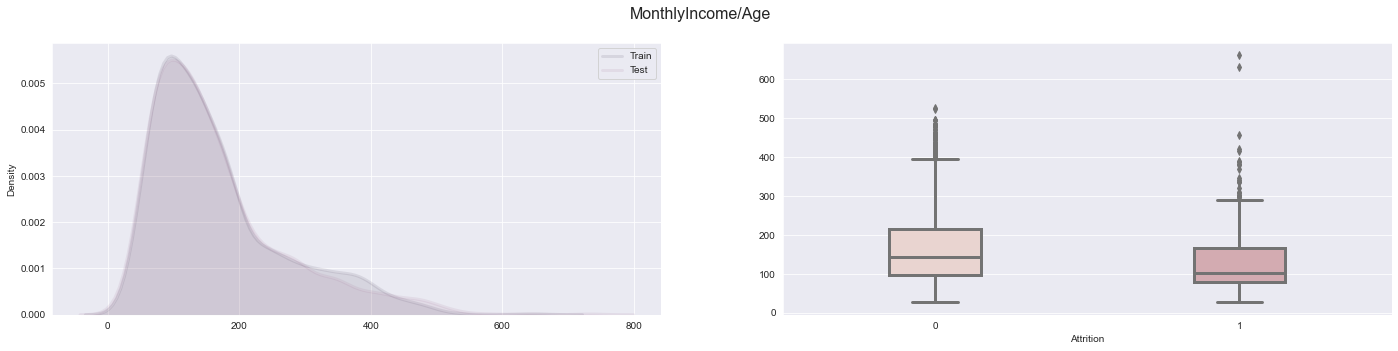

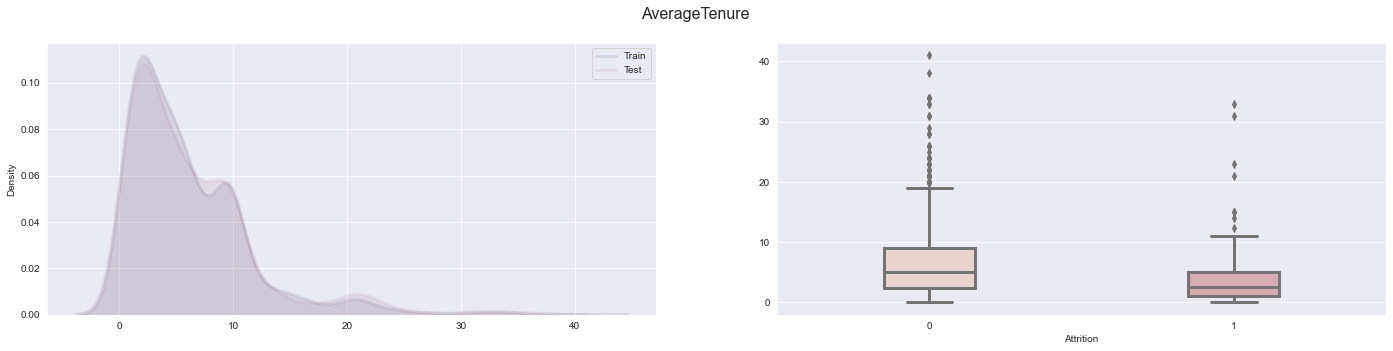

In [29]:
cols = ['MonthlyIncome/Age', 'AverageTenure']

for i in cols:
    
    # figure, axes
    sns.set_style('darkgrid')
    fig, ax = plt.subplots(1, 2, figsize=(24,5))
    # figure title
    fig.suptitle(i, fontsize=16)

    # train / test / original differences
    sns.kdeplot(train[i], shade=True, color=colors[5], ax=ax[0], label='Train', alpha=0.1, linewidth=3)
    sns.kdeplot(test[i], shade=True, color=colors[3], ax=ax[0], label='Test', alpha=0.1, linewidth=3)
    
    ax[0].set_xlabel('')
    ax[0].set_ylabel('Density')
    handles, labels = ax[0].get_legend_handles_labels()
    ax[0].legend(handles, labels)
    

    
    # boxplot
    sns.boxplot(y=i, x='Attrition', data=train, width=0.3, ax=ax[1], palette=colors, linewidth=3)
    ax[1].set_xlabel('Attrition')
    ax[1].set_ylabel('')

The median values for Attrition = 1 and Attrition = 0 are a bit different, though not much significant.

### Data Preparation:

**Encoding the categorical features:**

Few of the categorical features that are in string format need encoding. I will use Ordinal Encoder for them because they have multiple classes and one-hot encoding will lead to a huge number of features and may lead to over-fitting.

In [30]:
train.dtypes.sort_values()

AttritionRisk                 int32
Age_risk                      int32
HourlyRate_risk               int32
JobHopper                     int32
YearsAtCo_risk                int32
Distance_risk                 int32
Attrition                     int64
YearsWithCurrManager          int64
YearsSinceLastPromotion       int64
YearsInCurrentRole            int64
PercentSalaryHike             int64
WorkLifeBalance               int64
TrainingTimesLastYear         int64
TotalWorkingYears             int64
StockOptionLevel              int64
StandardHours                 int64
RelationshipSatisfaction      int64
PerformanceRating             int64
YearsAtCompany                int64
id                            int64
EmployeeCount                 int64
MonthlyRate                   int64
MonthlyIncome                 int64
JobSatisfaction               int64
Age                           int64
JobLevel                      int64
JobInvolvement                int64
HourlyRate                  

In [31]:
## Features that require encoding:
enc_features = ['BusinessTravel', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Department', 'OverTime']

In [32]:
ord_enc = OrdinalEncoder()
ord_enc.fit(train[enc_features])
train[enc_features] = ord_enc.transform(train[enc_features])
test[enc_features] = ord_enc.transform(test[enc_features])

In [33]:
train.dtypes.sort_values()

AttritionRisk                 int32
Age_risk                      int32
HourlyRate_risk               int32
JobHopper                     int32
YearsAtCo_risk                int32
Distance_risk                 int32
Attrition                     int64
YearsWithCurrManager          int64
YearsSinceLastPromotion       int64
YearsInCurrentRole            int64
PercentSalaryHike             int64
WorkLifeBalance               int64
TrainingTimesLastYear         int64
TotalWorkingYears             int64
StockOptionLevel              int64
StandardHours                 int64
RelationshipSatisfaction      int64
PerformanceRating             int64
YearsAtCompany                int64
id                            int64
EmployeeCount                 int64
MonthlyRate                   int64
MonthlyIncome                 int64
JobSatisfaction               int64
Age                           int64
JobLevel                      int64
JobInvolvement                int64
HourlyRate                  

In [34]:
train.head()

,id,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,...,YearsWithCurrManager,Attrition,MonthlyIncome/Age,Age_risk,HourlyRate_risk,Distance_risk,YearsAtCo_risk,AverageTenure,JobHopper,AttritionRisk
0,0,36,1.0,599,1.0,24,3,3.0,1,4,...,8,0,72.111111,0,1,1,0,10.0,0,2
1,1,35,2.0,921,2.0,8,3,4.0,1,1,...,3,0,82.828571,0,1,0,0,4.0,0,1
2,2,32,2.0,718,2.0,26,3,2.0,1,3,...,2,0,144.593750,1,0,1,1,4.0,0,3
3,3,38,2.0,1488,1.0,2,3,3.0,1,3,...,2,0,140.710526,0,1,0,0,5.0,0,1
4,4,50,2.0,1017,1.0,5,4,3.0,1,2,...,10,1,380.660000,0,1,0,0,31.0,0,1


**Getting rid of unnecessary variables:**

Dropping the `id`, `EmployeeCount`, `Over18` and `StandardHours` variables.

In [35]:
train.drop(['id', 'EmployeeCount', 'Over18', 'StandardHours'], axis=1, inplace=True)
test.drop(['id', 'EmployeeCount', 'Over18', 'StandardHours'], axis=1, inplace=True)

**Separating features and target:**

In [36]:
X = train.drop(['Attrition'], axis=1)
y = train['Attrition']
X_test = test.copy()

**Scaling the features using Standard Scaler:**

In [37]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_test = scaler.transform(X_test)

In [38]:
train.drop(['Attrition'], axis=1).columns

Index(['Age', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome',
       'Education', 'EducationField', 'EnvironmentSatisfaction', 'Gender',
       'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobRole',
       'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome', 'MonthlyRate',
       'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike',
       'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager', 'MonthlyIncome/Age', 'Age_risk',
       'HourlyRate_risk', 'Distance_risk', 'YearsAtCo_risk', 'AverageTenure',
       'JobHopper', 'AttritionRisk'],
      dtype='object')

### Modelling:

In [39]:
def cross_validate(X, y, model):
    
    ## Figure, axes:
    sns.set_style('darkgrid')
    fig, ax = plt.subplots(2, 1, figsize=(8,12))
    ax[0].set_title("ROC-AUC Curve")
    ax[0].set_xlabel("False Positive Rate")
    ax[0].set_ylabel("True Positive Rate")
    ax[1].set_title("Importances")
    
    
    skf = StratifiedKFold(n_splits = 10,
                          shuffle = True,
                          random_state = 1337)
    cv_scores = []
    model_importances = []
    
    for fold, (train_id, val_id) in enumerate(skf.split(X, y)):
        X_train, X_valid = X[train_id], X[val_id]
        y_train, y_valid = y[train_id], y[val_id]
        
        model.fit(X_train, y_train)
        model_importances.append(model.feature_importances_)
        
        y_pred = model.predict_proba(X_valid)[:, 1]
        auc_score = roc_auc_score(y_valid, y_pred)
        cv_scores.append(auc_score)
        fpr, tpr, thresholds = roc_curve(y_valid, y_pred)
        roc_auc = auc(fpr, tpr)
        display = RocCurveDisplay(fpr = fpr,
                        tpr = tpr,
                        roc_auc = roc_auc,
                        estimator_name = 'model')
        display.plot(ax = ax[0])
        
        print(f'Fold {fold} \t auc: {auc_score}')
        print('\n-------------------------------\n')
    
    df_importances = pd.DataFrame(model_importances,
                                  columns = train.drop(['Attrition'], axis=1).columns).apply(np.mean, axis=0).sort_values()
    df_importances.plot(kind = 'barh',
                        align = 'center',
                        width = 0.4,
                        ax = ax[1],
                        color = 'blue',
                        edgecolor = 'black')
    
    avg_auc = np.mean(cv_scores)
    print(f"Average AUC: {avg_auc}")

**XGBoost Classifier:**

In [40]:
model = XGBClassifier()

param_grid = {
    'n_estimators': [50, 100, 150, 200, 500, 1000],
    'learning_rate': [0.01, 0.1, 0.2, 0.25, 0.3],
    'max_depth': [3, 4, 5, 7],
    'min_child_weight': [4, 5, 6],
    'subsample': [0.6, 0.7, 0.75],
    'colsample_bytree': [0.25, 0.3, 0.35]
}

cv = StratifiedKFold(n_splits = 10,
                     shuffle = True,
                     random_state=1337)

grid_search = GridSearchCV(model,
                           param_grid = param_grid,
                           cv = cv,
                           n_jobs = -1)

grid_search.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=1337, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                      

In [41]:
print("Best Hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best Hyperparameters:  {'colsample_bytree': 0.25, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.7}
Best score:  0.8962503564299972


[09:08:18] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "learnin_rate" } are not used.

Fold 0 	 auc: 0.7476351351351351

-------------------------------

[09:08:18] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "learnin_rate" } are not used.

Fold 1 	 auc: 0.7756756756756757

-------------------------------

[09:08:18] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "learnin_rate" } are not used.

Fold 2 	 auc: 0.8209459459459459

-------------------------------

[09:08:18] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "learnin_rate" } are no

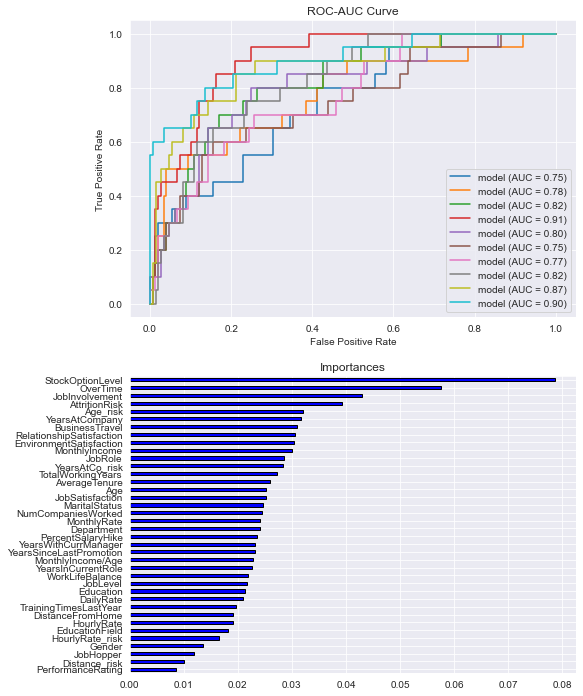

In [42]:
xgb_params = {
    'n_estimators': 100,
    'max_depth': 3,
    'learnin_rate': 0.1,
    'min_child_weight': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.25
}
xgb_clf = XGBClassifier(**xgb_params)
cross_validate(X, y, xgb_clf)

**LGBM Classifier:**

[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] min_gain_to_split is set=1.4, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.4
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] bagging_fraction is set=0.45, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45
[LightGBM] [Warning] lambda_l2 is set=0.6, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6
[LightGBM] [Warning] num_iterations is set=275, num_rounds=275 will be ignored. Current value: num_iterations=275
Fold 0 	 auc: 0.7746621621621622

-------------------------------

[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0

Fold 9 	 auc: 0.8833333333333333

-------------------------------

Average AUC: 0.828037323037323


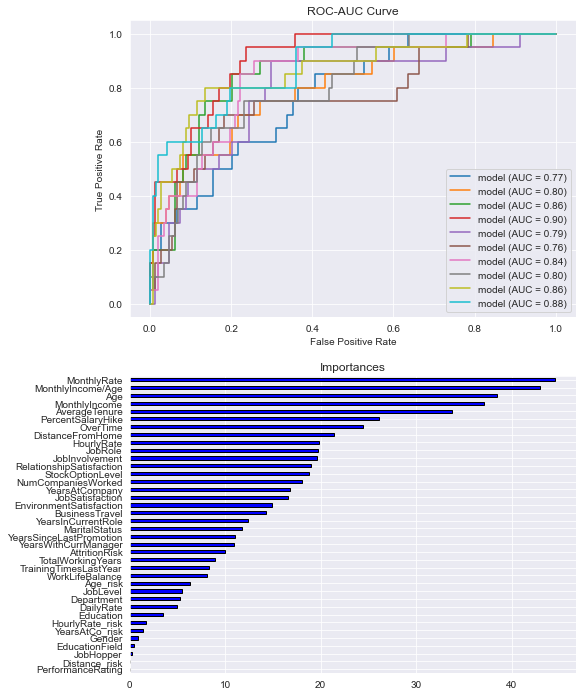

In [43]:
lgbm_params = {'n_estimators': 400,
                 'num_rounds': 275,
                 'learning_rate': 0.1,
                 'num_leaves': 200,
                 'max_depth': 9,
                 'min_data_in_leaf': 45,
                 'lambda_l1': 0.01,
                 'lambda_l2': 0.6,
                 'min_gain_to_split': 1.40,
                 'bagging_fraction': 0.45,
                 'feature_fraction': 0.3}
lgbm_clf = lgbm.LGBMClassifier(**lgbm_params)
cross_validate(X, y, lgbm_clf)

**CatBoost Classifier:**

0:	learn: 0.6159552	total: 150ms	remaining: 2m 30s
1:	learn: 0.5610080	total: 152ms	remaining: 1m 15s
2:	learn: 0.5139551	total: 154ms	remaining: 51s
3:	learn: 0.4788265	total: 155ms	remaining: 38.5s
4:	learn: 0.4533335	total: 156ms	remaining: 31.1s
5:	learn: 0.4334260	total: 157ms	remaining: 26s
6:	learn: 0.4178508	total: 159ms	remaining: 22.5s
7:	learn: 0.3981892	total: 160ms	remaining: 19.8s
8:	learn: 0.3860137	total: 161ms	remaining: 17.7s
9:	learn: 0.3743741	total: 162ms	remaining: 16.1s
10:	learn: 0.3672729	total: 163ms	remaining: 14.7s
11:	learn: 0.3611498	total: 164ms	remaining: 13.5s
12:	learn: 0.3574960	total: 166ms	remaining: 12.6s
13:	learn: 0.3537599	total: 167ms	remaining: 11.8s
14:	learn: 0.3507219	total: 168ms	remaining: 11s
15:	learn: 0.3477952	total: 169ms	remaining: 10.4s
16:	learn: 0.3465800	total: 170ms	remaining: 9.86s
17:	learn: 0.3456098	total: 173ms	remaining: 9.42s
18:	learn: 0.3446561	total: 174ms	remaining: 9.01s
19:	learn: 0.3439923	total: 176ms	remaining: 

215:	learn: 0.2596619	total: 523ms	remaining: 1.9s
216:	learn: 0.2594111	total: 525ms	remaining: 1.89s
217:	learn: 0.2592543	total: 527ms	remaining: 1.89s
218:	learn: 0.2589439	total: 529ms	remaining: 1.88s
219:	learn: 0.2586713	total: 530ms	remaining: 1.88s
220:	learn: 0.2586218	total: 532ms	remaining: 1.87s
221:	learn: 0.2585017	total: 533ms	remaining: 1.87s
222:	learn: 0.2581484	total: 535ms	remaining: 1.86s
223:	learn: 0.2581388	total: 536ms	remaining: 1.86s
224:	learn: 0.2580851	total: 538ms	remaining: 1.85s
225:	learn: 0.2580280	total: 539ms	remaining: 1.84s
226:	learn: 0.2579616	total: 540ms	remaining: 1.84s
227:	learn: 0.2576715	total: 542ms	remaining: 1.83s
228:	learn: 0.2575070	total: 543ms	remaining: 1.83s
229:	learn: 0.2573920	total: 545ms	remaining: 1.82s
230:	learn: 0.2572987	total: 548ms	remaining: 1.82s
231:	learn: 0.2571944	total: 550ms	remaining: 1.82s
232:	learn: 0.2569260	total: 551ms	remaining: 1.81s
233:	learn: 0.2568270	total: 553ms	remaining: 1.81s
234:	learn: 0

463:	learn: 0.2361518	total: 910ms	remaining: 1.05s
464:	learn: 0.2360834	total: 911ms	remaining: 1.05s
465:	learn: 0.2358566	total: 912ms	remaining: 1.04s
466:	learn: 0.2358012	total: 913ms	remaining: 1.04s
467:	learn: 0.2357838	total: 915ms	remaining: 1.04s
468:	learn: 0.2357769	total: 916ms	remaining: 1.04s
469:	learn: 0.2357280	total: 919ms	remaining: 1.04s
470:	learn: 0.2356534	total: 921ms	remaining: 1.03s
471:	learn: 0.2354915	total: 922ms	remaining: 1.03s
472:	learn: 0.2354209	total: 923ms	remaining: 1.03s
473:	learn: 0.2353338	total: 924ms	remaining: 1.02s
474:	learn: 0.2353337	total: 926ms	remaining: 1.02s
475:	learn: 0.2352355	total: 928ms	remaining: 1.02s
476:	learn: 0.2351962	total: 930ms	remaining: 1.02s
477:	learn: 0.2350970	total: 932ms	remaining: 1.02s
478:	learn: 0.2350008	total: 933ms	remaining: 1.01s
479:	learn: 0.2350007	total: 935ms	remaining: 1.01s
480:	learn: 0.2348906	total: 936ms	remaining: 1.01s
481:	learn: 0.2348582	total: 937ms	remaining: 1.01s
482:	learn: 

634:	learn: 0.2265746	total: 1.16s	remaining: 668ms
635:	learn: 0.2265746	total: 1.16s	remaining: 666ms
636:	learn: 0.2265403	total: 1.16s	remaining: 664ms
637:	learn: 0.2264880	total: 1.17s	remaining: 662ms
638:	learn: 0.2264878	total: 1.17s	remaining: 660ms
639:	learn: 0.2264710	total: 1.17s	remaining: 658ms
640:	learn: 0.2264711	total: 1.17s	remaining: 656ms
641:	learn: 0.2263866	total: 1.17s	remaining: 654ms
642:	learn: 0.2262756	total: 1.17s	remaining: 652ms
643:	learn: 0.2261737	total: 1.18s	remaining: 650ms
644:	learn: 0.2261737	total: 1.18s	remaining: 651ms
645:	learn: 0.2260474	total: 1.18s	remaining: 649ms
646:	learn: 0.2260008	total: 1.19s	remaining: 647ms
647:	learn: 0.2259395	total: 1.19s	remaining: 645ms
648:	learn: 0.2259385	total: 1.19s	remaining: 643ms
649:	learn: 0.2258896	total: 1.19s	remaining: 641ms
650:	learn: 0.2258217	total: 1.19s	remaining: 639ms
651:	learn: 0.2257987	total: 1.19s	remaining: 638ms
652:	learn: 0.2257456	total: 1.2s	remaining: 636ms
653:	learn: 0

898:	learn: 0.2167707	total: 1.53s	remaining: 172ms
899:	learn: 0.2167707	total: 1.54s	remaining: 171ms
900:	learn: 0.2167327	total: 1.54s	remaining: 169ms
901:	learn: 0.2167320	total: 1.54s	remaining: 167ms
902:	learn: 0.2167314	total: 1.54s	remaining: 165ms
903:	learn: 0.2167129	total: 1.54s	remaining: 164ms
904:	learn: 0.2166906	total: 1.54s	remaining: 162ms
905:	learn: 0.2166460	total: 1.54s	remaining: 160ms
906:	learn: 0.2166222	total: 1.54s	remaining: 158ms
907:	learn: 0.2166215	total: 1.54s	remaining: 157ms
908:	learn: 0.2165972	total: 1.55s	remaining: 155ms
909:	learn: 0.2165344	total: 1.55s	remaining: 153ms
910:	learn: 0.2164808	total: 1.55s	remaining: 151ms
911:	learn: 0.2164720	total: 1.55s	remaining: 150ms
912:	learn: 0.2163980	total: 1.55s	remaining: 148ms
913:	learn: 0.2162993	total: 1.55s	remaining: 146ms
914:	learn: 0.2162395	total: 1.55s	remaining: 144ms
915:	learn: 0.2161590	total: 1.55s	remaining: 143ms
916:	learn: 0.2161198	total: 1.55s	remaining: 141ms
917:	learn: 

62:	learn: 0.3098357	total: 124ms	remaining: 1.85s
63:	learn: 0.3094072	total: 126ms	remaining: 1.85s
64:	learn: 0.3077862	total: 128ms	remaining: 1.84s
65:	learn: 0.3077198	total: 130ms	remaining: 1.83s
66:	learn: 0.3069228	total: 131ms	remaining: 1.83s
67:	learn: 0.3069171	total: 135ms	remaining: 1.84s
68:	learn: 0.3065209	total: 136ms	remaining: 1.84s
69:	learn: 0.3061200	total: 138ms	remaining: 1.83s
70:	learn: 0.3057822	total: 140ms	remaining: 1.83s
71:	learn: 0.3054450	total: 142ms	remaining: 1.83s
72:	learn: 0.3052291	total: 145ms	remaining: 1.84s
73:	learn: 0.3049511	total: 146ms	remaining: 1.83s
74:	learn: 0.3045732	total: 150ms	remaining: 1.85s
75:	learn: 0.3037663	total: 152ms	remaining: 1.84s
76:	learn: 0.3036339	total: 153ms	remaining: 1.84s
77:	learn: 0.3029771	total: 155ms	remaining: 1.83s
78:	learn: 0.3027891	total: 157ms	remaining: 1.83s
79:	learn: 0.3020185	total: 160ms	remaining: 1.84s
80:	learn: 0.3015800	total: 162ms	remaining: 1.83s
81:	learn: 0.3014667	total: 163

255:	learn: 0.2599247	total: 521ms	remaining: 1.51s
256:	learn: 0.2598580	total: 524ms	remaining: 1.51s
257:	learn: 0.2598577	total: 525ms	remaining: 1.51s
258:	learn: 0.2594019	total: 529ms	remaining: 1.51s
259:	learn: 0.2590759	total: 532ms	remaining: 1.51s
260:	learn: 0.2590756	total: 533ms	remaining: 1.51s
261:	learn: 0.2589212	total: 535ms	remaining: 1.5s
262:	learn: 0.2586795	total: 536ms	remaining: 1.5s
263:	learn: 0.2586407	total: 538ms	remaining: 1.5s
264:	learn: 0.2586091	total: 540ms	remaining: 1.5s
265:	learn: 0.2584738	total: 541ms	remaining: 1.49s
266:	learn: 0.2584041	total: 543ms	remaining: 1.49s
267:	learn: 0.2582755	total: 545ms	remaining: 1.49s
268:	learn: 0.2581952	total: 546ms	remaining: 1.48s
269:	learn: 0.2579327	total: 548ms	remaining: 1.48s
270:	learn: 0.2578906	total: 550ms	remaining: 1.48s
271:	learn: 0.2578770	total: 551ms	remaining: 1.48s
272:	learn: 0.2578724	total: 553ms	remaining: 1.47s
273:	learn: 0.2577570	total: 555ms	remaining: 1.47s
274:	learn: 0.25

414:	learn: 0.2436450	total: 906ms	remaining: 1.28s
415:	learn: 0.2436205	total: 909ms	remaining: 1.27s
416:	learn: 0.2436204	total: 911ms	remaining: 1.27s
417:	learn: 0.2435500	total: 913ms	remaining: 1.27s
418:	learn: 0.2435367	total: 915ms	remaining: 1.27s
419:	learn: 0.2433809	total: 916ms	remaining: 1.26s
420:	learn: 0.2432958	total: 918ms	remaining: 1.26s
421:	learn: 0.2431063	total: 921ms	remaining: 1.26s
422:	learn: 0.2429969	total: 923ms	remaining: 1.26s
423:	learn: 0.2428832	total: 925ms	remaining: 1.26s
424:	learn: 0.2426873	total: 928ms	remaining: 1.25s
425:	learn: 0.2425752	total: 932ms	remaining: 1.25s
426:	learn: 0.2424613	total: 933ms	remaining: 1.25s
427:	learn: 0.2423414	total: 937ms	remaining: 1.25s
428:	learn: 0.2422263	total: 942ms	remaining: 1.25s
429:	learn: 0.2421488	total: 944ms	remaining: 1.25s
430:	learn: 0.2419910	total: 947ms	remaining: 1.25s
431:	learn: 0.2419463	total: 949ms	remaining: 1.25s
432:	learn: 0.2418590	total: 952ms	remaining: 1.25s
433:	learn: 

632:	learn: 0.2292181	total: 1.28s	remaining: 743ms
633:	learn: 0.2291764	total: 1.28s	remaining: 741ms
634:	learn: 0.2291344	total: 1.28s	remaining: 738ms
635:	learn: 0.2291342	total: 1.28s	remaining: 735ms
636:	learn: 0.2291169	total: 1.29s	remaining: 733ms
637:	learn: 0.2290716	total: 1.29s	remaining: 731ms
638:	learn: 0.2290715	total: 1.29s	remaining: 729ms
639:	learn: 0.2289799	total: 1.29s	remaining: 726ms
640:	learn: 0.2289398	total: 1.29s	remaining: 724ms
641:	learn: 0.2288844	total: 1.29s	remaining: 721ms
642:	learn: 0.2288279	total: 1.29s	remaining: 719ms
643:	learn: 0.2287141	total: 1.3s	remaining: 718ms
644:	learn: 0.2286545	total: 1.3s	remaining: 716ms
645:	learn: 0.2286448	total: 1.3s	remaining: 714ms
646:	learn: 0.2285947	total: 1.3s	remaining: 711ms
647:	learn: 0.2285946	total: 1.3s	remaining: 709ms
648:	learn: 0.2285475	total: 1.31s	remaining: 706ms
649:	learn: 0.2285098	total: 1.31s	remaining: 704ms
650:	learn: 0.2284318	total: 1.31s	remaining: 701ms
651:	learn: 0.228

817:	learn: 0.2207914	total: 1.65s	remaining: 368ms
818:	learn: 0.2207908	total: 1.66s	remaining: 366ms
819:	learn: 0.2207908	total: 1.66s	remaining: 364ms
820:	learn: 0.2207618	total: 1.66s	remaining: 362ms
821:	learn: 0.2207337	total: 1.66s	remaining: 360ms
822:	learn: 0.2207317	total: 1.66s	remaining: 358ms
823:	learn: 0.2207317	total: 1.67s	remaining: 356ms
824:	learn: 0.2207229	total: 1.67s	remaining: 354ms
825:	learn: 0.2207229	total: 1.67s	remaining: 352ms
826:	learn: 0.2207209	total: 1.67s	remaining: 349ms
827:	learn: 0.2206133	total: 1.67s	remaining: 347ms
828:	learn: 0.2206132	total: 1.67s	remaining: 345ms
829:	learn: 0.2206083	total: 1.68s	remaining: 343ms
830:	learn: 0.2205318	total: 1.68s	remaining: 342ms
831:	learn: 0.2205080	total: 1.68s	remaining: 340ms
832:	learn: 0.2204903	total: 1.69s	remaining: 338ms
833:	learn: 0.2204632	total: 1.69s	remaining: 336ms
834:	learn: 0.2203978	total: 1.69s	remaining: 334ms
835:	learn: 0.2203607	total: 1.69s	remaining: 332ms
836:	learn: 

1:	learn: 0.5591340	total: 3.71ms	remaining: 1.85s
2:	learn: 0.5108121	total: 5.41ms	remaining: 1.8s
3:	learn: 0.4781577	total: 8.57ms	remaining: 2.13s
4:	learn: 0.4522212	total: 10.2ms	remaining: 2.03s
5:	learn: 0.4309703	total: 11.5ms	remaining: 1.91s
6:	learn: 0.4155427	total: 12.8ms	remaining: 1.82s
7:	learn: 0.3957899	total: 14.5ms	remaining: 1.8s
8:	learn: 0.3860160	total: 16.1ms	remaining: 1.77s
9:	learn: 0.3764739	total: 18.6ms	remaining: 1.84s
10:	learn: 0.3688054	total: 20.5ms	remaining: 1.84s
11:	learn: 0.3639998	total: 21.9ms	remaining: 1.8s
12:	learn: 0.3606581	total: 23.1ms	remaining: 1.75s
13:	learn: 0.3553848	total: 24.2ms	remaining: 1.71s
14:	learn: 0.3527636	total: 25.3ms	remaining: 1.66s
15:	learn: 0.3510761	total: 26.3ms	remaining: 1.62s
16:	learn: 0.3496804	total: 27.5ms	remaining: 1.59s
17:	learn: 0.3486496	total: 30.3ms	remaining: 1.65s
18:	learn: 0.3468087	total: 32.5ms	remaining: 1.68s
19:	learn: 0.3434985	total: 33.8ms	remaining: 1.66s
20:	learn: 0.3414294	tot

197:	learn: 0.2712442	total: 377ms	remaining: 1.53s
198:	learn: 0.2710836	total: 379ms	remaining: 1.52s
199:	learn: 0.2710833	total: 380ms	remaining: 1.52s
200:	learn: 0.2710831	total: 381ms	remaining: 1.51s
201:	learn: 0.2710831	total: 382ms	remaining: 1.51s
202:	learn: 0.2708540	total: 384ms	remaining: 1.51s
203:	learn: 0.2708539	total: 386ms	remaining: 1.51s
204:	learn: 0.2706189	total: 387ms	remaining: 1.5s
205:	learn: 0.2703273	total: 389ms	remaining: 1.5s
206:	learn: 0.2702024	total: 391ms	remaining: 1.5s
207:	learn: 0.2700492	total: 392ms	remaining: 1.49s
208:	learn: 0.2698752	total: 393ms	remaining: 1.49s
209:	learn: 0.2698751	total: 396ms	remaining: 1.49s
210:	learn: 0.2697509	total: 398ms	remaining: 1.49s
211:	learn: 0.2697471	total: 400ms	remaining: 1.49s
212:	learn: 0.2697471	total: 402ms	remaining: 1.48s
213:	learn: 0.2690465	total: 404ms	remaining: 1.48s
214:	learn: 0.2687768	total: 405ms	remaining: 1.48s
215:	learn: 0.2686405	total: 410ms	remaining: 1.49s
216:	learn: 0.2

361:	learn: 0.2522302	total: 744ms	remaining: 1.31s
362:	learn: 0.2519857	total: 745ms	remaining: 1.31s
363:	learn: 0.2518468	total: 748ms	remaining: 1.31s
364:	learn: 0.2516129	total: 749ms	remaining: 1.3s
365:	learn: 0.2515195	total: 751ms	remaining: 1.3s
366:	learn: 0.2514757	total: 754ms	remaining: 1.3s
367:	learn: 0.2513684	total: 755ms	remaining: 1.3s
368:	learn: 0.2512924	total: 757ms	remaining: 1.29s
369:	learn: 0.2511415	total: 761ms	remaining: 1.29s
370:	learn: 0.2511414	total: 764ms	remaining: 1.29s
371:	learn: 0.2511413	total: 766ms	remaining: 1.29s
372:	learn: 0.2511035	total: 769ms	remaining: 1.29s
373:	learn: 0.2510939	total: 771ms	remaining: 1.29s
374:	learn: 0.2508947	total: 775ms	remaining: 1.29s
375:	learn: 0.2508660	total: 777ms	remaining: 1.29s
376:	learn: 0.2507694	total: 779ms	remaining: 1.29s
377:	learn: 0.2507209	total: 782ms	remaining: 1.29s
378:	learn: 0.2506122	total: 785ms	remaining: 1.29s
379:	learn: 0.2504552	total: 787ms	remaining: 1.28s
380:	learn: 0.25

579:	learn: 0.2372706	total: 1.11s	remaining: 806ms
580:	learn: 0.2372017	total: 1.12s	remaining: 805ms
581:	learn: 0.2371882	total: 1.12s	remaining: 803ms
582:	learn: 0.2371835	total: 1.12s	remaining: 801ms
583:	learn: 0.2371017	total: 1.12s	remaining: 799ms
584:	learn: 0.2370165	total: 1.12s	remaining: 797ms
585:	learn: 0.2369996	total: 1.12s	remaining: 794ms
586:	learn: 0.2369105	total: 1.13s	remaining: 792ms
587:	learn: 0.2368956	total: 1.13s	remaining: 790ms
588:	learn: 0.2368428	total: 1.13s	remaining: 788ms
589:	learn: 0.2367771	total: 1.13s	remaining: 785ms
590:	learn: 0.2366485	total: 1.13s	remaining: 783ms
591:	learn: 0.2365441	total: 1.13s	remaining: 781ms
592:	learn: 0.2365440	total: 1.14s	remaining: 779ms
593:	learn: 0.2365327	total: 1.14s	remaining: 778ms
594:	learn: 0.2365251	total: 1.14s	remaining: 775ms
595:	learn: 0.2364400	total: 1.14s	remaining: 773ms
596:	learn: 0.2363936	total: 1.14s	remaining: 771ms
597:	learn: 0.2363095	total: 1.14s	remaining: 768ms
598:	learn: 

740:	learn: 0.2288639	total: 1.37s	remaining: 479ms
741:	learn: 0.2288598	total: 1.37s	remaining: 477ms
742:	learn: 0.2287625	total: 1.37s	remaining: 475ms
743:	learn: 0.2286541	total: 1.38s	remaining: 474ms
744:	learn: 0.2285621	total: 1.38s	remaining: 472ms
745:	learn: 0.2284739	total: 1.38s	remaining: 470ms
746:	learn: 0.2284412	total: 1.38s	remaining: 468ms
747:	learn: 0.2284369	total: 1.38s	remaining: 466ms
748:	learn: 0.2283775	total: 1.38s	remaining: 464ms
749:	learn: 0.2282773	total: 1.39s	remaining: 462ms
750:	learn: 0.2282456	total: 1.39s	remaining: 460ms
751:	learn: 0.2282453	total: 1.39s	remaining: 458ms
752:	learn: 0.2282256	total: 1.39s	remaining: 456ms
753:	learn: 0.2281392	total: 1.39s	remaining: 454ms
754:	learn: 0.2281376	total: 1.39s	remaining: 452ms
755:	learn: 0.2281094	total: 1.39s	remaining: 450ms
756:	learn: 0.2279615	total: 1.4s	remaining: 448ms
757:	learn: 0.2278817	total: 1.4s	remaining: 446ms
758:	learn: 0.2278782	total: 1.4s	remaining: 444ms
759:	learn: 0.2

961:	learn: 0.2205541	total: 1.75s	remaining: 69.3ms
962:	learn: 0.2205271	total: 1.76s	remaining: 67.5ms
963:	learn: 0.2205013	total: 1.76s	remaining: 65.7ms
964:	learn: 0.2204783	total: 1.76s	remaining: 63.9ms
965:	learn: 0.2204700	total: 1.76s	remaining: 62.1ms
966:	learn: 0.2204261	total: 1.77s	remaining: 60.3ms
967:	learn: 0.2203396	total: 1.77s	remaining: 58.4ms
968:	learn: 0.2203268	total: 1.77s	remaining: 56.6ms
969:	learn: 0.2202623	total: 1.77s	remaining: 54.8ms
970:	learn: 0.2202529	total: 1.77s	remaining: 52.9ms
971:	learn: 0.2202409	total: 1.77s	remaining: 51.1ms
972:	learn: 0.2202344	total: 1.78s	remaining: 49.3ms
973:	learn: 0.2202342	total: 1.78s	remaining: 47.5ms
974:	learn: 0.2201673	total: 1.78s	remaining: 45.7ms
975:	learn: 0.2201673	total: 1.78s	remaining: 43.8ms
976:	learn: 0.2201357	total: 1.79s	remaining: 42.1ms
977:	learn: 0.2200838	total: 1.79s	remaining: 40.3ms
978:	learn: 0.2200838	total: 1.79s	remaining: 38.4ms
979:	learn: 0.2200701	total: 1.79s	remaining: 

141:	learn: 0.2844019	total: 266ms	remaining: 1.6s
142:	learn: 0.2843054	total: 268ms	remaining: 1.6s
143:	learn: 0.2837572	total: 270ms	remaining: 1.6s
144:	learn: 0.2834007	total: 272ms	remaining: 1.6s
145:	learn: 0.2825748	total: 274ms	remaining: 1.6s
146:	learn: 0.2821177	total: 275ms	remaining: 1.6s
147:	learn: 0.2819461	total: 277ms	remaining: 1.59s
148:	learn: 0.2810626	total: 279ms	remaining: 1.59s
149:	learn: 0.2807786	total: 282ms	remaining: 1.6s
150:	learn: 0.2807757	total: 284ms	remaining: 1.59s
151:	learn: 0.2806891	total: 285ms	remaining: 1.59s
152:	learn: 0.2803188	total: 287ms	remaining: 1.59s
153:	learn: 0.2800589	total: 292ms	remaining: 1.6s
154:	learn: 0.2798245	total: 294ms	remaining: 1.6s
155:	learn: 0.2797575	total: 296ms	remaining: 1.6s
156:	learn: 0.2797570	total: 297ms	remaining: 1.6s
157:	learn: 0.2790988	total: 299ms	remaining: 1.59s
158:	learn: 0.2790439	total: 301ms	remaining: 1.59s
159:	learn: 0.2790246	total: 303ms	remaining: 1.59s
160:	learn: 0.2789283	t

338:	learn: 0.2529875	total: 676ms	remaining: 1.32s
339:	learn: 0.2529834	total: 677ms	remaining: 1.31s
340:	learn: 0.2529588	total: 680ms	remaining: 1.31s
341:	learn: 0.2529099	total: 682ms	remaining: 1.31s
342:	learn: 0.2529020	total: 684ms	remaining: 1.31s
343:	learn: 0.2529019	total: 685ms	remaining: 1.31s
344:	learn: 0.2528338	total: 689ms	remaining: 1.31s
345:	learn: 0.2526546	total: 692ms	remaining: 1.31s
346:	learn: 0.2526233	total: 693ms	remaining: 1.3s
347:	learn: 0.2525302	total: 696ms	remaining: 1.3s
348:	learn: 0.2523647	total: 698ms	remaining: 1.3s
349:	learn: 0.2523646	total: 700ms	remaining: 1.3s
350:	learn: 0.2521984	total: 702ms	remaining: 1.3s
351:	learn: 0.2521407	total: 704ms	remaining: 1.3s
352:	learn: 0.2521202	total: 706ms	remaining: 1.29s
353:	learn: 0.2520410	total: 708ms	remaining: 1.29s
354:	learn: 0.2520016	total: 710ms	remaining: 1.29s
355:	learn: 0.2519618	total: 712ms	remaining: 1.29s
356:	learn: 0.2519617	total: 713ms	remaining: 1.28s
357:	learn: 0.2517

530:	learn: 0.2399194	total: 1.03s	remaining: 909ms
531:	learn: 0.2399055	total: 1.03s	remaining: 906ms
532:	learn: 0.2398109	total: 1.03s	remaining: 903ms
533:	learn: 0.2396587	total: 1.03s	remaining: 901ms
534:	learn: 0.2395645	total: 1.03s	remaining: 898ms
535:	learn: 0.2395027	total: 1.03s	remaining: 896ms
536:	learn: 0.2394174	total: 1.04s	remaining: 893ms
537:	learn: 0.2390297	total: 1.04s	remaining: 891ms
538:	learn: 0.2389180	total: 1.04s	remaining: 888ms
539:	learn: 0.2387996	total: 1.04s	remaining: 885ms
540:	learn: 0.2387996	total: 1.04s	remaining: 883ms
541:	learn: 0.2386780	total: 1.04s	remaining: 880ms
542:	learn: 0.2385952	total: 1.04s	remaining: 880ms
543:	learn: 0.2385532	total: 1.05s	remaining: 877ms
544:	learn: 0.2385123	total: 1.05s	remaining: 875ms
545:	learn: 0.2384756	total: 1.05s	remaining: 872ms
546:	learn: 0.2384082	total: 1.05s	remaining: 870ms
547:	learn: 0.2383626	total: 1.05s	remaining: 867ms
548:	learn: 0.2383032	total: 1.05s	remaining: 865ms
549:	learn: 

725:	learn: 0.2301672	total: 1.28s	remaining: 484ms
726:	learn: 0.2301402	total: 1.28s	remaining: 482ms
727:	learn: 0.2300375	total: 1.28s	remaining: 480ms
728:	learn: 0.2300005	total: 1.28s	remaining: 478ms
729:	learn: 0.2299878	total: 1.29s	remaining: 476ms
730:	learn: 0.2298923	total: 1.29s	remaining: 474ms
731:	learn: 0.2298792	total: 1.29s	remaining: 472ms
732:	learn: 0.2298592	total: 1.29s	remaining: 470ms
733:	learn: 0.2298592	total: 1.29s	remaining: 468ms
734:	learn: 0.2298184	total: 1.29s	remaining: 466ms
735:	learn: 0.2298083	total: 1.29s	remaining: 464ms
736:	learn: 0.2297870	total: 1.3s	remaining: 463ms
737:	learn: 0.2297399	total: 1.3s	remaining: 462ms
738:	learn: 0.2297399	total: 1.3s	remaining: 460ms
739:	learn: 0.2297064	total: 1.3s	remaining: 458ms
740:	learn: 0.2296789	total: 1.3s	remaining: 456ms
741:	learn: 0.2296596	total: 1.31s	remaining: 454ms
742:	learn: 0.2296554	total: 1.31s	remaining: 452ms
743:	learn: 0.2294213	total: 1.31s	remaining: 450ms
744:	learn: 0.229

909:	learn: 0.2234838	total: 1.55s	remaining: 153ms
910:	learn: 0.2234597	total: 1.55s	remaining: 151ms
911:	learn: 0.2234338	total: 1.55s	remaining: 149ms
912:	learn: 0.2233558	total: 1.55s	remaining: 148ms
913:	learn: 0.2232921	total: 1.55s	remaining: 146ms
914:	learn: 0.2232582	total: 1.55s	remaining: 144ms
915:	learn: 0.2231679	total: 1.55s	remaining: 142ms
916:	learn: 0.2231615	total: 1.55s	remaining: 141ms
917:	learn: 0.2231531	total: 1.55s	remaining: 139ms
918:	learn: 0.2231191	total: 1.56s	remaining: 137ms
919:	learn: 0.2230862	total: 1.56s	remaining: 135ms
920:	learn: 0.2230309	total: 1.56s	remaining: 134ms
921:	learn: 0.2230309	total: 1.56s	remaining: 132ms
922:	learn: 0.2230270	total: 1.56s	remaining: 130ms
923:	learn: 0.2229758	total: 1.56s	remaining: 129ms
924:	learn: 0.2229193	total: 1.56s	remaining: 127ms
925:	learn: 0.2228630	total: 1.57s	remaining: 125ms
926:	learn: 0.2228430	total: 1.57s	remaining: 123ms
927:	learn: 0.2228388	total: 1.57s	remaining: 122ms
928:	learn: 

136:	learn: 0.2775325	total: 143ms	remaining: 900ms
137:	learn: 0.2772132	total: 144ms	remaining: 899ms
138:	learn: 0.2768991	total: 145ms	remaining: 898ms
139:	learn: 0.2765443	total: 146ms	remaining: 897ms
140:	learn: 0.2765435	total: 147ms	remaining: 895ms
141:	learn: 0.2761985	total: 148ms	remaining: 893ms
142:	learn: 0.2761980	total: 149ms	remaining: 891ms
143:	learn: 0.2759911	total: 150ms	remaining: 890ms
144:	learn: 0.2759547	total: 151ms	remaining: 890ms
145:	learn: 0.2749730	total: 152ms	remaining: 889ms
146:	learn: 0.2746847	total: 153ms	remaining: 889ms
147:	learn: 0.2744341	total: 154ms	remaining: 888ms
148:	learn: 0.2740481	total: 155ms	remaining: 887ms
149:	learn: 0.2737877	total: 156ms	remaining: 886ms
150:	learn: 0.2736193	total: 157ms	remaining: 885ms
151:	learn: 0.2728216	total: 158ms	remaining: 884ms
152:	learn: 0.2728205	total: 160ms	remaining: 887ms
153:	learn: 0.2724646	total: 161ms	remaining: 887ms
154:	learn: 0.2724639	total: 162ms	remaining: 885ms
155:	learn: 

371:	learn: 0.2412631	total: 409ms	remaining: 690ms
372:	learn: 0.2411830	total: 410ms	remaining: 689ms
373:	learn: 0.2411472	total: 411ms	remaining: 688ms
374:	learn: 0.2411004	total: 412ms	remaining: 687ms
375:	learn: 0.2410636	total: 413ms	remaining: 686ms
376:	learn: 0.2410553	total: 414ms	remaining: 684ms
377:	learn: 0.2409672	total: 415ms	remaining: 683ms
378:	learn: 0.2409074	total: 416ms	remaining: 682ms
379:	learn: 0.2407956	total: 417ms	remaining: 681ms
380:	learn: 0.2406713	total: 418ms	remaining: 680ms
381:	learn: 0.2406714	total: 419ms	remaining: 678ms
382:	learn: 0.2405645	total: 420ms	remaining: 677ms
383:	learn: 0.2405028	total: 421ms	remaining: 676ms
384:	learn: 0.2404119	total: 423ms	remaining: 675ms
385:	learn: 0.2403093	total: 424ms	remaining: 674ms
386:	learn: 0.2402342	total: 426ms	remaining: 674ms
387:	learn: 0.2402342	total: 426ms	remaining: 673ms
388:	learn: 0.2402290	total: 429ms	remaining: 673ms
389:	learn: 0.2400793	total: 431ms	remaining: 675ms
390:	learn: 

586:	learn: 0.2271973	total: 679ms	remaining: 478ms
587:	learn: 0.2271186	total: 682ms	remaining: 478ms
588:	learn: 0.2271184	total: 683ms	remaining: 477ms
589:	learn: 0.2270993	total: 685ms	remaining: 476ms
590:	learn: 0.2270992	total: 686ms	remaining: 475ms
591:	learn: 0.2270612	total: 688ms	remaining: 474ms
592:	learn: 0.2269723	total: 689ms	remaining: 473ms
593:	learn: 0.2268100	total: 690ms	remaining: 472ms
594:	learn: 0.2267668	total: 692ms	remaining: 471ms
595:	learn: 0.2267536	total: 694ms	remaining: 470ms
596:	learn: 0.2267522	total: 695ms	remaining: 469ms
597:	learn: 0.2266002	total: 696ms	remaining: 468ms
598:	learn: 0.2261926	total: 697ms	remaining: 467ms
599:	learn: 0.2261749	total: 698ms	remaining: 466ms
600:	learn: 0.2260908	total: 700ms	remaining: 465ms
601:	learn: 0.2260149	total: 702ms	remaining: 464ms
602:	learn: 0.2258951	total: 703ms	remaining: 463ms
603:	learn: 0.2257896	total: 705ms	remaining: 462ms
604:	learn: 0.2257753	total: 706ms	remaining: 461ms
605:	learn: 

775:	learn: 0.2178531	total: 927ms	remaining: 268ms
776:	learn: 0.2178178	total: 929ms	remaining: 267ms
777:	learn: 0.2177901	total: 930ms	remaining: 265ms
778:	learn: 0.2176934	total: 934ms	remaining: 265ms
779:	learn: 0.2176269	total: 937ms	remaining: 264ms
780:	learn: 0.2175759	total: 939ms	remaining: 263ms
781:	learn: 0.2175688	total: 940ms	remaining: 262ms
782:	learn: 0.2175686	total: 943ms	remaining: 261ms
783:	learn: 0.2174363	total: 945ms	remaining: 260ms
784:	learn: 0.2173230	total: 947ms	remaining: 259ms
785:	learn: 0.2172816	total: 949ms	remaining: 258ms
786:	learn: 0.2172274	total: 951ms	remaining: 257ms
787:	learn: 0.2171236	total: 952ms	remaining: 256ms
788:	learn: 0.2171235	total: 954ms	remaining: 255ms
789:	learn: 0.2171233	total: 955ms	remaining: 254ms
790:	learn: 0.2170320	total: 956ms	remaining: 253ms
791:	learn: 0.2170265	total: 959ms	remaining: 252ms
792:	learn: 0.2169729	total: 960ms	remaining: 251ms
793:	learn: 0.2169469	total: 962ms	remaining: 249ms
794:	learn: 

980:	learn: 0.2104749	total: 1.19s	remaining: 23ms
981:	learn: 0.2104688	total: 1.19s	remaining: 21.8ms
982:	learn: 0.2104588	total: 1.19s	remaining: 20.6ms
983:	learn: 0.2104392	total: 1.19s	remaining: 19.4ms
984:	learn: 0.2103139	total: 1.19s	remaining: 18.2ms
985:	learn: 0.2103139	total: 1.19s	remaining: 16.9ms
986:	learn: 0.2103135	total: 1.19s	remaining: 15.7ms
987:	learn: 0.2103095	total: 1.2s	remaining: 14.5ms
988:	learn: 0.2102546	total: 1.2s	remaining: 13.3ms
989:	learn: 0.2102216	total: 1.2s	remaining: 12.1ms
990:	learn: 0.2102070	total: 1.2s	remaining: 10.9ms
991:	learn: 0.2101712	total: 1.2s	remaining: 9.68ms
992:	learn: 0.2101313	total: 1.2s	remaining: 8.47ms
993:	learn: 0.2101259	total: 1.2s	remaining: 7.27ms
994:	learn: 0.2101076	total: 1.21s	remaining: 6.06ms
995:	learn: 0.2101075	total: 1.21s	remaining: 4.84ms
996:	learn: 0.2100817	total: 1.21s	remaining: 3.63ms
997:	learn: 0.2100158	total: 1.21s	remaining: 2.42ms
998:	learn: 0.2099506	total: 1.21s	remaining: 1.21ms
99

207:	learn: 0.2617177	total: 322ms	remaining: 1.23s
208:	learn: 0.2611786	total: 325ms	remaining: 1.23s
209:	learn: 0.2608779	total: 326ms	remaining: 1.23s
210:	learn: 0.2604404	total: 328ms	remaining: 1.23s
211:	learn: 0.2603562	total: 329ms	remaining: 1.22s
212:	learn: 0.2601112	total: 331ms	remaining: 1.22s
213:	learn: 0.2600549	total: 332ms	remaining: 1.22s
214:	learn: 0.2600151	total: 334ms	remaining: 1.22s
215:	learn: 0.2600057	total: 335ms	remaining: 1.22s
216:	learn: 0.2596247	total: 337ms	remaining: 1.22s
217:	learn: 0.2595139	total: 338ms	remaining: 1.21s
218:	learn: 0.2592948	total: 340ms	remaining: 1.21s
219:	learn: 0.2590821	total: 342ms	remaining: 1.21s
220:	learn: 0.2589273	total: 346ms	remaining: 1.22s
221:	learn: 0.2589270	total: 347ms	remaining: 1.22s
222:	learn: 0.2587566	total: 349ms	remaining: 1.22s
223:	learn: 0.2587562	total: 350ms	remaining: 1.21s
224:	learn: 0.2581141	total: 352ms	remaining: 1.21s
225:	learn: 0.2578616	total: 353ms	remaining: 1.21s
226:	learn: 

426:	learn: 0.2396385	total: 721ms	remaining: 968ms
427:	learn: 0.2394691	total: 724ms	remaining: 968ms
428:	learn: 0.2393026	total: 726ms	remaining: 966ms
429:	learn: 0.2392434	total: 728ms	remaining: 965ms
430:	learn: 0.2391924	total: 729ms	remaining: 963ms
431:	learn: 0.2391200	total: 731ms	remaining: 962ms
432:	learn: 0.2391126	total: 733ms	remaining: 960ms
433:	learn: 0.2389058	total: 735ms	remaining: 958ms
434:	learn: 0.2388472	total: 736ms	remaining: 956ms
435:	learn: 0.2388232	total: 749ms	remaining: 969ms
436:	learn: 0.2387037	total: 751ms	remaining: 967ms
437:	learn: 0.2386306	total: 753ms	remaining: 966ms
438:	learn: 0.2384914	total: 754ms	remaining: 964ms
439:	learn: 0.2384394	total: 758ms	remaining: 965ms
440:	learn: 0.2382626	total: 760ms	remaining: 963ms
441:	learn: 0.2379775	total: 762ms	remaining: 962ms
442:	learn: 0.2379775	total: 763ms	remaining: 960ms
443:	learn: 0.2378606	total: 765ms	remaining: 958ms
444:	learn: 0.2377600	total: 767ms	remaining: 956ms
445:	learn: 

591:	learn: 0.2296744	total: 990ms	remaining: 682ms
592:	learn: 0.2296277	total: 992ms	remaining: 681ms
593:	learn: 0.2294602	total: 993ms	remaining: 679ms
594:	learn: 0.2293618	total: 995ms	remaining: 677ms
595:	learn: 0.2292791	total: 996ms	remaining: 675ms
596:	learn: 0.2290685	total: 998ms	remaining: 673ms
597:	learn: 0.2289405	total: 999ms	remaining: 672ms
598:	learn: 0.2288407	total: 1s	remaining: 670ms
599:	learn: 0.2288081	total: 1s	remaining: 668ms
600:	learn: 0.2286918	total: 1s	remaining: 666ms
601:	learn: 0.2285379	total: 1s	remaining: 665ms
602:	learn: 0.2285002	total: 1.01s	remaining: 663ms
603:	learn: 0.2284537	total: 1.01s	remaining: 661ms
604:	learn: 0.2284531	total: 1.01s	remaining: 659ms
605:	learn: 0.2283956	total: 1.01s	remaining: 659ms
606:	learn: 0.2283559	total: 1.01s	remaining: 657ms
607:	learn: 0.2283079	total: 1.02s	remaining: 656ms
608:	learn: 0.2281963	total: 1.02s	remaining: 654ms
609:	learn: 0.2281825	total: 1.02s	remaining: 652ms
610:	learn: 0.2281515	to

769:	learn: 0.2207411	total: 1.26s	remaining: 377ms
770:	learn: 0.2207076	total: 1.26s	remaining: 375ms
771:	learn: 0.2206700	total: 1.26s	remaining: 374ms
772:	learn: 0.2206582	total: 1.27s	remaining: 372ms
773:	learn: 0.2206202	total: 1.27s	remaining: 370ms
774:	learn: 0.2205743	total: 1.27s	remaining: 369ms
775:	learn: 0.2205431	total: 1.27s	remaining: 367ms
776:	learn: 0.2204801	total: 1.27s	remaining: 365ms
777:	learn: 0.2204588	total: 1.27s	remaining: 364ms
778:	learn: 0.2203978	total: 1.28s	remaining: 362ms
779:	learn: 0.2203079	total: 1.28s	remaining: 360ms
780:	learn: 0.2203027	total: 1.28s	remaining: 359ms
781:	learn: 0.2201495	total: 1.28s	remaining: 357ms
782:	learn: 0.2201217	total: 1.28s	remaining: 356ms
783:	learn: 0.2200925	total: 1.29s	remaining: 355ms
784:	learn: 0.2200924	total: 1.29s	remaining: 353ms
785:	learn: 0.2200747	total: 1.29s	remaining: 351ms
786:	learn: 0.2200516	total: 1.29s	remaining: 349ms
787:	learn: 0.2199443	total: 1.29s	remaining: 348ms
788:	learn: 

936:	learn: 0.2136924	total: 1.53s	remaining: 103ms
937:	learn: 0.2136924	total: 1.53s	remaining: 101ms
938:	learn: 0.2136918	total: 1.54s	remaining: 99.8ms
939:	learn: 0.2136709	total: 1.54s	remaining: 98.2ms
940:	learn: 0.2136638	total: 1.54s	remaining: 96.5ms
941:	learn: 0.2136191	total: 1.54s	remaining: 94.8ms
942:	learn: 0.2135750	total: 1.54s	remaining: 93.2ms
943:	learn: 0.2135545	total: 1.54s	remaining: 91.5ms
944:	learn: 0.2135492	total: 1.54s	remaining: 89.9ms
945:	learn: 0.2134962	total: 1.54s	remaining: 88.2ms
946:	learn: 0.2134961	total: 1.55s	remaining: 86.6ms
947:	learn: 0.2134536	total: 1.55s	remaining: 84.9ms
948:	learn: 0.2134462	total: 1.55s	remaining: 83.2ms
949:	learn: 0.2134214	total: 1.55s	remaining: 81.6ms
950:	learn: 0.2133890	total: 1.55s	remaining: 79.9ms
951:	learn: 0.2133889	total: 1.55s	remaining: 78.3ms
952:	learn: 0.2133623	total: 1.55s	remaining: 76.6ms
953:	learn: 0.2133123	total: 1.55s	remaining: 74.9ms
954:	learn: 0.2132368	total: 1.55s	remaining: 73

98:	learn: 0.2953163	total: 136ms	remaining: 1.23s
99:	learn: 0.2951159	total: 137ms	remaining: 1.23s
100:	learn: 0.2951052	total: 138ms	remaining: 1.23s
101:	learn: 0.2947253	total: 139ms	remaining: 1.22s
102:	learn: 0.2936321	total: 140ms	remaining: 1.22s
103:	learn: 0.2931926	total: 141ms	remaining: 1.22s
104:	learn: 0.2931911	total: 142ms	remaining: 1.21s
105:	learn: 0.2930246	total: 143ms	remaining: 1.21s
106:	learn: 0.2929559	total: 144ms	remaining: 1.2s
107:	learn: 0.2927146	total: 145ms	remaining: 1.2s
108:	learn: 0.2925729	total: 146ms	remaining: 1.2s
109:	learn: 0.2925236	total: 147ms	remaining: 1.19s
110:	learn: 0.2923182	total: 149ms	remaining: 1.19s
111:	learn: 0.2923176	total: 151ms	remaining: 1.2s
112:	learn: 0.2919025	total: 152ms	remaining: 1.2s
113:	learn: 0.2919020	total: 153ms	remaining: 1.19s
114:	learn: 0.2916310	total: 154ms	remaining: 1.19s
115:	learn: 0.2913414	total: 155ms	remaining: 1.18s
116:	learn: 0.2912635	total: 156ms	remaining: 1.18s
117:	learn: 0.29125

350:	learn: 0.2493608	total: 408ms	remaining: 755ms
351:	learn: 0.2492918	total: 409ms	remaining: 754ms
352:	learn: 0.2492126	total: 411ms	remaining: 753ms
353:	learn: 0.2490516	total: 412ms	remaining: 751ms
354:	learn: 0.2490165	total: 413ms	remaining: 750ms
355:	learn: 0.2488867	total: 414ms	remaining: 748ms
356:	learn: 0.2487022	total: 415ms	remaining: 747ms
357:	learn: 0.2486672	total: 415ms	remaining: 745ms
358:	learn: 0.2486256	total: 417ms	remaining: 744ms
359:	learn: 0.2485783	total: 418ms	remaining: 742ms
360:	learn: 0.2484322	total: 419ms	remaining: 741ms
361:	learn: 0.2482194	total: 420ms	remaining: 740ms
362:	learn: 0.2482193	total: 421ms	remaining: 738ms
363:	learn: 0.2481903	total: 422ms	remaining: 738ms
364:	learn: 0.2480804	total: 423ms	remaining: 736ms
365:	learn: 0.2480497	total: 424ms	remaining: 735ms
366:	learn: 0.2480487	total: 426ms	remaining: 735ms
367:	learn: 0.2480487	total: 428ms	remaining: 735ms
368:	learn: 0.2479959	total: 430ms	remaining: 735ms
369:	learn: 

575:	learn: 0.2328270	total: 674ms	remaining: 496ms
576:	learn: 0.2327338	total: 676ms	remaining: 495ms
577:	learn: 0.2327338	total: 678ms	remaining: 495ms
578:	learn: 0.2326542	total: 679ms	remaining: 494ms
579:	learn: 0.2326541	total: 681ms	remaining: 493ms
580:	learn: 0.2325839	total: 682ms	remaining: 492ms
581:	learn: 0.2324675	total: 684ms	remaining: 491ms
582:	learn: 0.2324195	total: 686ms	remaining: 491ms
583:	learn: 0.2323501	total: 688ms	remaining: 490ms
584:	learn: 0.2318207	total: 690ms	remaining: 489ms
585:	learn: 0.2317307	total: 692ms	remaining: 489ms
586:	learn: 0.2316751	total: 693ms	remaining: 488ms
587:	learn: 0.2316282	total: 695ms	remaining: 487ms
588:	learn: 0.2315499	total: 696ms	remaining: 486ms
589:	learn: 0.2314702	total: 698ms	remaining: 485ms
590:	learn: 0.2314704	total: 699ms	remaining: 484ms
591:	learn: 0.2314702	total: 700ms	remaining: 483ms
592:	learn: 0.2314207	total: 702ms	remaining: 482ms
593:	learn: 0.2313566	total: 703ms	remaining: 481ms
594:	learn: 

760:	learn: 0.2238575	total: 939ms	remaining: 295ms
761:	learn: 0.2238575	total: 940ms	remaining: 294ms
762:	learn: 0.2237968	total: 941ms	remaining: 292ms
763:	learn: 0.2237742	total: 942ms	remaining: 291ms
764:	learn: 0.2237744	total: 943ms	remaining: 290ms
765:	learn: 0.2237156	total: 945ms	remaining: 289ms
766:	learn: 0.2236563	total: 946ms	remaining: 287ms
767:	learn: 0.2236554	total: 948ms	remaining: 286ms
768:	learn: 0.2236407	total: 949ms	remaining: 285ms
769:	learn: 0.2235430	total: 951ms	remaining: 284ms
770:	learn: 0.2235406	total: 952ms	remaining: 283ms
771:	learn: 0.2234910	total: 953ms	remaining: 282ms
772:	learn: 0.2234340	total: 956ms	remaining: 281ms
773:	learn: 0.2233623	total: 958ms	remaining: 280ms
774:	learn: 0.2232999	total: 960ms	remaining: 279ms
775:	learn: 0.2232570	total: 962ms	remaining: 278ms
776:	learn: 0.2232560	total: 964ms	remaining: 277ms
777:	learn: 0.2231935	total: 966ms	remaining: 276ms
778:	learn: 0.2231826	total: 968ms	remaining: 274ms
779:	learn: 

954:	learn: 0.2170843	total: 1.18s	remaining: 55.6ms
955:	learn: 0.2170843	total: 1.18s	remaining: 54.4ms
956:	learn: 0.2169754	total: 1.18s	remaining: 53.2ms
957:	learn: 0.2169362	total: 1.18s	remaining: 51.9ms
958:	learn: 0.2168875	total: 1.19s	remaining: 50.7ms
959:	learn: 0.2168476	total: 1.19s	remaining: 49.4ms
960:	learn: 0.2168236	total: 1.19s	remaining: 48.2ms
961:	learn: 0.2168235	total: 1.19s	remaining: 47ms
962:	learn: 0.2167887	total: 1.19s	remaining: 45.7ms
963:	learn: 0.2167629	total: 1.19s	remaining: 44.5ms
964:	learn: 0.2166904	total: 1.19s	remaining: 43.2ms
965:	learn: 0.2166876	total: 1.19s	remaining: 42ms
966:	learn: 0.2166425	total: 1.19s	remaining: 40.8ms
967:	learn: 0.2166235	total: 1.2s	remaining: 39.5ms
968:	learn: 0.2166040	total: 1.2s	remaining: 38.3ms
969:	learn: 0.2165808	total: 1.2s	remaining: 37.1ms
970:	learn: 0.2163867	total: 1.2s	remaining: 35.8ms
971:	learn: 0.2163762	total: 1.2s	remaining: 34.6ms
972:	learn: 0.2163761	total: 1.2s	remaining: 33.4ms
973

159:	learn: 0.2763903	total: 174ms	remaining: 911ms
160:	learn: 0.2763896	total: 175ms	remaining: 911ms
161:	learn: 0.2762761	total: 176ms	remaining: 910ms
162:	learn: 0.2762609	total: 177ms	remaining: 909ms
163:	learn: 0.2760840	total: 178ms	remaining: 908ms
164:	learn: 0.2758438	total: 179ms	remaining: 907ms
165:	learn: 0.2756991	total: 181ms	remaining: 909ms
166:	learn: 0.2754945	total: 182ms	remaining: 910ms
167:	learn: 0.2754495	total: 183ms	remaining: 908ms
168:	learn: 0.2753555	total: 185ms	remaining: 910ms
169:	learn: 0.2752367	total: 186ms	remaining: 910ms
170:	learn: 0.2752145	total: 188ms	remaining: 909ms
171:	learn: 0.2750246	total: 190ms	remaining: 912ms
172:	learn: 0.2746188	total: 191ms	remaining: 915ms
173:	learn: 0.2745510	total: 193ms	remaining: 918ms
174:	learn: 0.2744961	total: 195ms	remaining: 917ms
175:	learn: 0.2743048	total: 196ms	remaining: 917ms
176:	learn: 0.2738808	total: 197ms	remaining: 916ms
177:	learn: 0.2736715	total: 198ms	remaining: 915ms
178:	learn: 

383:	learn: 0.2456817	total: 431ms	remaining: 692ms
384:	learn: 0.2456389	total: 433ms	remaining: 691ms
385:	learn: 0.2456388	total: 434ms	remaining: 690ms
386:	learn: 0.2453725	total: 435ms	remaining: 689ms
387:	learn: 0.2453180	total: 436ms	remaining: 687ms
388:	learn: 0.2453180	total: 437ms	remaining: 686ms
389:	learn: 0.2452131	total: 438ms	remaining: 685ms
390:	learn: 0.2451356	total: 439ms	remaining: 684ms
391:	learn: 0.2451356	total: 440ms	remaining: 683ms
392:	learn: 0.2450543	total: 441ms	remaining: 682ms
393:	learn: 0.2449744	total: 442ms	remaining: 680ms
394:	learn: 0.2448829	total: 444ms	remaining: 679ms
395:	learn: 0.2446533	total: 445ms	remaining: 678ms
396:	learn: 0.2446331	total: 446ms	remaining: 678ms
397:	learn: 0.2446167	total: 448ms	remaining: 677ms
398:	learn: 0.2445711	total: 449ms	remaining: 676ms
399:	learn: 0.2445681	total: 450ms	remaining: 676ms
400:	learn: 0.2444695	total: 452ms	remaining: 676ms
401:	learn: 0.2444535	total: 454ms	remaining: 675ms
402:	learn: 

557:	learn: 0.2343365	total: 681ms	remaining: 540ms
558:	learn: 0.2341944	total: 683ms	remaining: 539ms
559:	learn: 0.2340850	total: 685ms	remaining: 538ms
560:	learn: 0.2340470	total: 687ms	remaining: 538ms
561:	learn: 0.2340372	total: 689ms	remaining: 537ms
562:	learn: 0.2339933	total: 691ms	remaining: 536ms
563:	learn: 0.2339055	total: 692ms	remaining: 535ms
564:	learn: 0.2337970	total: 694ms	remaining: 534ms
565:	learn: 0.2337342	total: 696ms	remaining: 533ms
566:	learn: 0.2337214	total: 697ms	remaining: 532ms
567:	learn: 0.2337183	total: 702ms	remaining: 534ms
568:	learn: 0.2336245	total: 704ms	remaining: 533ms
569:	learn: 0.2334844	total: 707ms	remaining: 533ms
570:	learn: 0.2334756	total: 709ms	remaining: 533ms
571:	learn: 0.2334089	total: 711ms	remaining: 532ms
572:	learn: 0.2334089	total: 712ms	remaining: 531ms
573:	learn: 0.2334089	total: 714ms	remaining: 530ms
574:	learn: 0.2334088	total: 715ms	remaining: 529ms
575:	learn: 0.2333956	total: 717ms	remaining: 528ms
576:	learn: 

792:	learn: 0.2244542	total: 1.08s	remaining: 283ms
793:	learn: 0.2244355	total: 1.09s	remaining: 282ms
794:	learn: 0.2244230	total: 1.09s	remaining: 281ms
795:	learn: 0.2244069	total: 1.09s	remaining: 280ms
796:	learn: 0.2243404	total: 1.09s	remaining: 278ms
797:	learn: 0.2242849	total: 1.09s	remaining: 277ms
798:	learn: 0.2242811	total: 1.09s	remaining: 275ms
799:	learn: 0.2242648	total: 1.1s	remaining: 274ms
800:	learn: 0.2242648	total: 1.1s	remaining: 273ms
801:	learn: 0.2242299	total: 1.1s	remaining: 271ms
802:	learn: 0.2241653	total: 1.1s	remaining: 270ms
803:	learn: 0.2240944	total: 1.1s	remaining: 269ms
804:	learn: 0.2240143	total: 1.1s	remaining: 267ms
805:	learn: 0.2240143	total: 1.1s	remaining: 266ms
806:	learn: 0.2239322	total: 1.11s	remaining: 265ms
807:	learn: 0.2238765	total: 1.11s	remaining: 263ms
808:	learn: 0.2238376	total: 1.11s	remaining: 262ms
809:	learn: 0.2237550	total: 1.11s	remaining: 261ms
810:	learn: 0.2237539	total: 1.11s	remaining: 259ms
811:	learn: 0.22373

960:	learn: 0.2190819	total: 1.36s	remaining: 55ms
961:	learn: 0.2190298	total: 1.36s	remaining: 53.7ms
962:	learn: 0.2189876	total: 1.36s	remaining: 52.3ms
963:	learn: 0.2189877	total: 1.36s	remaining: 50.9ms
964:	learn: 0.2189562	total: 1.36s	remaining: 49.5ms
965:	learn: 0.2188958	total: 1.36s	remaining: 48ms
966:	learn: 0.2188494	total: 1.37s	remaining: 46.6ms
967:	learn: 0.2188493	total: 1.37s	remaining: 45.2ms
968:	learn: 0.2188253	total: 1.37s	remaining: 43.8ms
969:	learn: 0.2187442	total: 1.37s	remaining: 42.4ms
970:	learn: 0.2187227	total: 1.37s	remaining: 41ms
971:	learn: 0.2186388	total: 1.37s	remaining: 39.6ms
972:	learn: 0.2186387	total: 1.38s	remaining: 38.2ms
973:	learn: 0.2185577	total: 1.38s	remaining: 36.8ms
974:	learn: 0.2185167	total: 1.38s	remaining: 35.4ms
975:	learn: 0.2185124	total: 1.38s	remaining: 34ms
976:	learn: 0.2184973	total: 1.38s	remaining: 32.6ms
977:	learn: 0.2184482	total: 1.38s	remaining: 31.1ms
978:	learn: 0.2184332	total: 1.39s	remaining: 29.7ms
9

164:	learn: 0.2744682	total: 276ms	remaining: 1.39s
165:	learn: 0.2744197	total: 277ms	remaining: 1.39s
166:	learn: 0.2742732	total: 279ms	remaining: 1.39s
167:	learn: 0.2740760	total: 281ms	remaining: 1.39s
168:	learn: 0.2736175	total: 282ms	remaining: 1.39s
169:	learn: 0.2734540	total: 284ms	remaining: 1.39s
170:	learn: 0.2729681	total: 286ms	remaining: 1.38s
171:	learn: 0.2726085	total: 287ms	remaining: 1.38s
172:	learn: 0.2725801	total: 289ms	remaining: 1.38s
173:	learn: 0.2725792	total: 291ms	remaining: 1.38s
174:	learn: 0.2724147	total: 292ms	remaining: 1.38s
175:	learn: 0.2724017	total: 294ms	remaining: 1.38s
176:	learn: 0.2723705	total: 295ms	remaining: 1.37s
177:	learn: 0.2723702	total: 296ms	remaining: 1.37s
178:	learn: 0.2722687	total: 300ms	remaining: 1.38s
179:	learn: 0.2718720	total: 302ms	remaining: 1.37s
180:	learn: 0.2715831	total: 304ms	remaining: 1.37s
181:	learn: 0.2712910	total: 305ms	remaining: 1.37s
182:	learn: 0.2709668	total: 307ms	remaining: 1.37s
183:	learn: 

330:	learn: 0.2518913	total: 545ms	remaining: 1.1s
331:	learn: 0.2518889	total: 547ms	remaining: 1.1s
332:	learn: 0.2517718	total: 550ms	remaining: 1.1s
333:	learn: 0.2514998	total: 552ms	remaining: 1.1s
334:	learn: 0.2512414	total: 553ms	remaining: 1.1s
335:	learn: 0.2512025	total: 555ms	remaining: 1.1s
336:	learn: 0.2511807	total: 557ms	remaining: 1.09s
337:	learn: 0.2511405	total: 558ms	remaining: 1.09s
338:	learn: 0.2511181	total: 560ms	remaining: 1.09s
339:	learn: 0.2510239	total: 562ms	remaining: 1.09s
340:	learn: 0.2508134	total: 563ms	remaining: 1.09s
341:	learn: 0.2507357	total: 565ms	remaining: 1.09s
342:	learn: 0.2506570	total: 569ms	remaining: 1.09s
343:	learn: 0.2506308	total: 571ms	remaining: 1.09s
344:	learn: 0.2505716	total: 572ms	remaining: 1.09s
345:	learn: 0.2504350	total: 574ms	remaining: 1.08s
346:	learn: 0.2502756	total: 576ms	remaining: 1.08s
347:	learn: 0.2501048	total: 577ms	remaining: 1.08s
348:	learn: 0.2498936	total: 579ms	remaining: 1.08s
349:	learn: 0.2496

488:	learn: 0.2403969	total: 801ms	remaining: 837ms
489:	learn: 0.2402967	total: 803ms	remaining: 835ms
490:	learn: 0.2402790	total: 805ms	remaining: 834ms
491:	learn: 0.2402789	total: 806ms	remaining: 832ms
492:	learn: 0.2400651	total: 808ms	remaining: 831ms
493:	learn: 0.2400652	total: 809ms	remaining: 829ms
494:	learn: 0.2400597	total: 811ms	remaining: 827ms
495:	learn: 0.2400293	total: 812ms	remaining: 826ms
496:	learn: 0.2400257	total: 814ms	remaining: 824ms
497:	learn: 0.2400257	total: 815ms	remaining: 822ms
498:	learn: 0.2400103	total: 817ms	remaining: 820ms
499:	learn: 0.2399212	total: 819ms	remaining: 819ms
500:	learn: 0.2399163	total: 821ms	remaining: 818ms
501:	learn: 0.2399149	total: 822ms	remaining: 816ms
502:	learn: 0.2398365	total: 824ms	remaining: 814ms
503:	learn: 0.2398142	total: 825ms	remaining: 812ms
504:	learn: 0.2397818	total: 827ms	remaining: 811ms
505:	learn: 0.2397564	total: 828ms	remaining: 809ms
506:	learn: 0.2397564	total: 830ms	remaining: 807ms
507:	learn: 

653:	learn: 0.2322731	total: 1.05s	remaining: 557ms
654:	learn: 0.2322451	total: 1.05s	remaining: 555ms
655:	learn: 0.2322106	total: 1.05s	remaining: 553ms
656:	learn: 0.2321161	total: 1.06s	remaining: 552ms
657:	learn: 0.2320170	total: 1.06s	remaining: 550ms
658:	learn: 0.2320048	total: 1.06s	remaining: 548ms
659:	learn: 0.2319721	total: 1.06s	remaining: 547ms
660:	learn: 0.2318709	total: 1.06s	remaining: 545ms
661:	learn: 0.2317890	total: 1.06s	remaining: 544ms
662:	learn: 0.2317441	total: 1.07s	remaining: 542ms
663:	learn: 0.2317230	total: 1.07s	remaining: 540ms
664:	learn: 0.2317042	total: 1.07s	remaining: 539ms
665:	learn: 0.2317041	total: 1.07s	remaining: 537ms
666:	learn: 0.2316836	total: 1.07s	remaining: 536ms
667:	learn: 0.2316572	total: 1.07s	remaining: 534ms
668:	learn: 0.2316333	total: 1.08s	remaining: 533ms
669:	learn: 0.2316332	total: 1.08s	remaining: 531ms
670:	learn: 0.2315894	total: 1.08s	remaining: 529ms
671:	learn: 0.2315895	total: 1.08s	remaining: 527ms
672:	learn: 

822:	learn: 0.2259071	total: 1.32s	remaining: 285ms
823:	learn: 0.2258913	total: 1.32s	remaining: 283ms
824:	learn: 0.2258296	total: 1.33s	remaining: 281ms
825:	learn: 0.2258271	total: 1.33s	remaining: 280ms
826:	learn: 0.2258148	total: 1.33s	remaining: 278ms
827:	learn: 0.2257398	total: 1.33s	remaining: 276ms
828:	learn: 0.2257397	total: 1.33s	remaining: 275ms
829:	learn: 0.2256119	total: 1.33s	remaining: 273ms
830:	learn: 0.2256119	total: 1.33s	remaining: 271ms
831:	learn: 0.2255867	total: 1.34s	remaining: 270ms
832:	learn: 0.2255696	total: 1.34s	remaining: 268ms
833:	learn: 0.2255260	total: 1.34s	remaining: 267ms
834:	learn: 0.2255063	total: 1.34s	remaining: 265ms
835:	learn: 0.2254125	total: 1.34s	remaining: 263ms
836:	learn: 0.2253631	total: 1.34s	remaining: 262ms
837:	learn: 0.2253391	total: 1.34s	remaining: 260ms
838:	learn: 0.2253271	total: 1.35s	remaining: 258ms
839:	learn: 0.2252855	total: 1.35s	remaining: 257ms
840:	learn: 0.2251853	total: 1.35s	remaining: 255ms
841:	learn: 

993:	learn: 0.2197163	total: 1.59s	remaining: 9.59ms
994:	learn: 0.2196962	total: 1.59s	remaining: 7.99ms
995:	learn: 0.2196232	total: 1.59s	remaining: 6.39ms
996:	learn: 0.2196105	total: 1.59s	remaining: 4.79ms
997:	learn: 0.2196103	total: 1.59s	remaining: 3.19ms
998:	learn: 0.2195806	total: 1.6s	remaining: 1.6ms
999:	learn: 0.2195463	total: 1.6s	remaining: 0us
Fold 8 	 auc: 0.8962585034013606

-------------------------------

0:	learn: 0.6182070	total: 1.42ms	remaining: 1.42s
1:	learn: 0.5588781	total: 2.72ms	remaining: 1.36s
2:	learn: 0.5155339	total: 4.14ms	remaining: 1.38s
3:	learn: 0.4790775	total: 5.31ms	remaining: 1.32s
4:	learn: 0.4527693	total: 6.71ms	remaining: 1.34s
5:	learn: 0.4329263	total: 8.06ms	remaining: 1.33s
6:	learn: 0.4172407	total: 9.37ms	remaining: 1.33s
7:	learn: 0.4005915	total: 10.8ms	remaining: 1.33s
8:	learn: 0.3902404	total: 12.2ms	remaining: 1.34s
9:	learn: 0.3822330	total: 13.5ms	remaining: 1.33s
10:	learn: 0.3764036	total: 14.8ms	remaining: 1.33s
11:	le

219:	learn: 0.2698018	total: 299ms	remaining: 1.06s
220:	learn: 0.2695917	total: 301ms	remaining: 1.06s
221:	learn: 0.2693976	total: 303ms	remaining: 1.06s
222:	learn: 0.2688438	total: 304ms	remaining: 1.06s
223:	learn: 0.2688434	total: 306ms	remaining: 1.06s
224:	learn: 0.2688432	total: 307ms	remaining: 1.06s
225:	learn: 0.2688428	total: 309ms	remaining: 1.06s
226:	learn: 0.2684248	total: 310ms	remaining: 1.06s
227:	learn: 0.2683223	total: 311ms	remaining: 1.05s
228:	learn: 0.2681684	total: 313ms	remaining: 1.05s
229:	learn: 0.2681187	total: 314ms	remaining: 1.05s
230:	learn: 0.2681186	total: 316ms	remaining: 1.05s
231:	learn: 0.2679539	total: 318ms	remaining: 1.05s
232:	learn: 0.2675694	total: 319ms	remaining: 1.05s
233:	learn: 0.2675691	total: 321ms	remaining: 1.05s
234:	learn: 0.2675560	total: 322ms	remaining: 1.05s
235:	learn: 0.2674313	total: 324ms	remaining: 1.05s
236:	learn: 0.2672845	total: 327ms	remaining: 1.05s
237:	learn: 0.2672017	total: 329ms	remaining: 1.05s
238:	learn: 

385:	learn: 0.2514848	total: 566ms	remaining: 901ms
386:	learn: 0.2512873	total: 569ms	remaining: 902ms
387:	learn: 0.2511322	total: 572ms	remaining: 901ms
388:	learn: 0.2508357	total: 574ms	remaining: 901ms
389:	learn: 0.2508207	total: 576ms	remaining: 901ms
390:	learn: 0.2507339	total: 579ms	remaining: 901ms
391:	learn: 0.2507289	total: 581ms	remaining: 900ms
392:	learn: 0.2507290	total: 582ms	remaining: 899ms
393:	learn: 0.2507286	total: 584ms	remaining: 898ms
394:	learn: 0.2503401	total: 585ms	remaining: 897ms
395:	learn: 0.2502752	total: 587ms	remaining: 895ms
396:	learn: 0.2502367	total: 589ms	remaining: 894ms
397:	learn: 0.2501230	total: 591ms	remaining: 894ms
398:	learn: 0.2499858	total: 593ms	remaining: 893ms
399:	learn: 0.2497592	total: 594ms	remaining: 891ms
400:	learn: 0.2497022	total: 596ms	remaining: 890ms
401:	learn: 0.2496855	total: 597ms	remaining: 889ms
402:	learn: 0.2495976	total: 599ms	remaining: 888ms
403:	learn: 0.2494808	total: 601ms	remaining: 886ms
404:	learn: 

603:	learn: 0.2366651	total: 964ms	remaining: 632ms
604:	learn: 0.2366591	total: 965ms	remaining: 630ms
605:	learn: 0.2366569	total: 966ms	remaining: 628ms
606:	learn: 0.2366535	total: 968ms	remaining: 627ms
607:	learn: 0.2366182	total: 969ms	remaining: 625ms
608:	learn: 0.2365564	total: 971ms	remaining: 623ms
609:	learn: 0.2365144	total: 973ms	remaining: 622ms
610:	learn: 0.2365025	total: 974ms	remaining: 620ms
611:	learn: 0.2363833	total: 976ms	remaining: 619ms
612:	learn: 0.2363833	total: 977ms	remaining: 617ms
613:	learn: 0.2362815	total: 979ms	remaining: 615ms
614:	learn: 0.2361289	total: 981ms	remaining: 614ms
615:	learn: 0.2360753	total: 982ms	remaining: 612ms
616:	learn: 0.2360190	total: 984ms	remaining: 611ms
617:	learn: 0.2359532	total: 986ms	remaining: 609ms
618:	learn: 0.2359530	total: 987ms	remaining: 608ms
619:	learn: 0.2359384	total: 989ms	remaining: 606ms
620:	learn: 0.2358198	total: 990ms	remaining: 604ms
621:	learn: 0.2357712	total: 993ms	remaining: 604ms
622:	learn: 

764:	learn: 0.2289955	total: 1.23s	remaining: 379ms
765:	learn: 0.2289599	total: 1.23s	remaining: 377ms
766:	learn: 0.2289463	total: 1.24s	remaining: 376ms
767:	learn: 0.2288821	total: 1.24s	remaining: 374ms
768:	learn: 0.2288507	total: 1.24s	remaining: 372ms
769:	learn: 0.2288087	total: 1.24s	remaining: 371ms
770:	learn: 0.2288086	total: 1.24s	remaining: 369ms
771:	learn: 0.2287526	total: 1.24s	remaining: 368ms
772:	learn: 0.2287398	total: 1.25s	remaining: 366ms
773:	learn: 0.2287399	total: 1.25s	remaining: 364ms
774:	learn: 0.2287066	total: 1.25s	remaining: 363ms
775:	learn: 0.2286953	total: 1.25s	remaining: 361ms
776:	learn: 0.2286523	total: 1.25s	remaining: 360ms
777:	learn: 0.2286073	total: 1.25s	remaining: 358ms
778:	learn: 0.2286065	total: 1.26s	remaining: 357ms
779:	learn: 0.2285814	total: 1.26s	remaining: 355ms
780:	learn: 0.2284579	total: 1.26s	remaining: 354ms
781:	learn: 0.2284522	total: 1.26s	remaining: 352ms
782:	learn: 0.2284498	total: 1.26s	remaining: 350ms
783:	learn: 

956:	learn: 0.2224631	total: 1.51s	remaining: 67.8ms
957:	learn: 0.2223559	total: 1.51s	remaining: 66.2ms
958:	learn: 0.2223302	total: 1.51s	remaining: 64.6ms
959:	learn: 0.2222355	total: 1.51s	remaining: 63ms
960:	learn: 0.2222355	total: 1.51s	remaining: 61.4ms
961:	learn: 0.2221732	total: 1.51s	remaining: 59.9ms
962:	learn: 0.2221696	total: 1.52s	remaining: 58.3ms
963:	learn: 0.2221696	total: 1.52s	remaining: 56.7ms
964:	learn: 0.2221498	total: 1.52s	remaining: 55.1ms
965:	learn: 0.2221282	total: 1.52s	remaining: 53.5ms
966:	learn: 0.2221055	total: 1.52s	remaining: 51.9ms
967:	learn: 0.2221055	total: 1.52s	remaining: 50.4ms
968:	learn: 0.2220270	total: 1.52s	remaining: 48.8ms
969:	learn: 0.2219982	total: 1.53s	remaining: 47.2ms
970:	learn: 0.2219972	total: 1.53s	remaining: 45.7ms
971:	learn: 0.2219835	total: 1.53s	remaining: 44.1ms
972:	learn: 0.2219832	total: 1.53s	remaining: 42.6ms
973:	learn: 0.2219403	total: 1.53s	remaining: 41ms
974:	learn: 0.2219025	total: 1.54s	remaining: 39.4

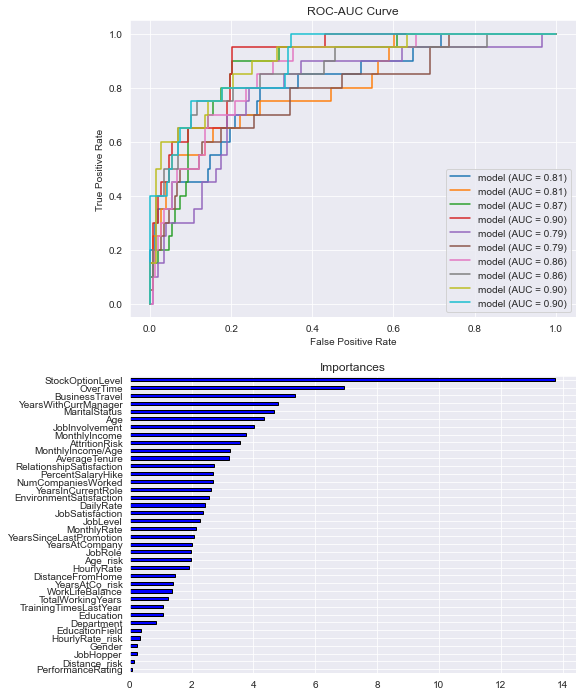

In [46]:
catboost_params = {'loss_function': 'CrossEntropy',
                     'learning_rate': 0.1,
                     'l2_leaf_reg': 0.01,
                     'colsample_bylevel': 0.05,
                     'depth': 1,
                     'boosting_type': 'Plain',
                     'bootstrap_type': 'Bernoulli',
                     'min_data_in_leaf': 20,
                     'one_hot_max_size': 15,
                     'subsample': 0.7}

catboost_clf = catboost.CatBoostClassifier(**catboost_params)

cross_validate(X, y, catboost_clf)

**Random Forest Classifier:**

Fold 0 	 auc: 0.772972972972973

-------------------------------

Fold 1 	 auc: 0.8300675675675675

-------------------------------

Fold 2 	 auc: 0.831081081081081

-------------------------------

Fold 3 	 auc: 0.8746621621621622

-------------------------------

Fold 4 	 auc: 0.8050675675675675

-------------------------------

Fold 5 	 auc: 0.7672297297297297

-------------------------------

Fold 6 	 auc: 0.8202702702702702

-------------------------------

Fold 7 	 auc: 0.7829931972789116

-------------------------------

Fold 8 	 auc: 0.8816326530612244

-------------------------------

Fold 9 	 auc: 0.8595238095238096

-------------------------------

Average AUC: 0.8225501011215297


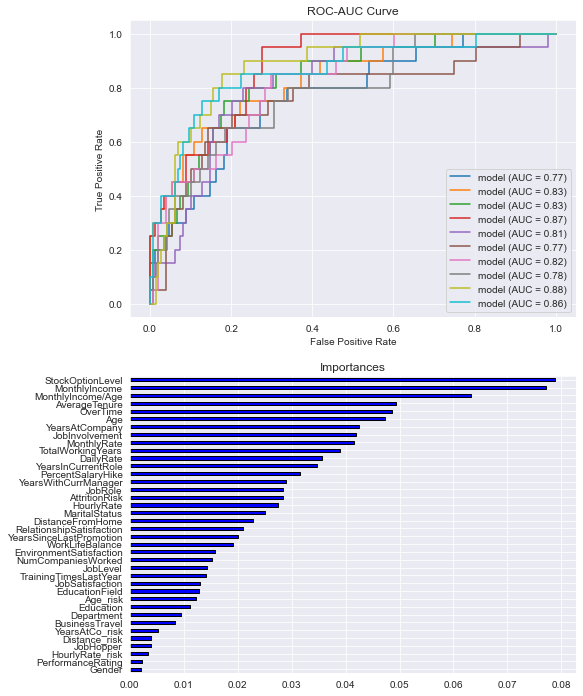

In [48]:
rf_params = {
    'n_estimators': 250,
    'max_depth': 9,
    'min_samples_split': 25,
    'bootstrap': True
}

rf_clf = RandomForestClassifier(**rf_params)
cross_validate(X, y, rf_clf)

### Final Submission:

Catboost gave the best results after the Cross-Validation, so I choose Catboost classifier to make final predictions.

In [54]:
catboost_clf.fit(X, y)
catboost_pred = catboost_clf.predict_proba(X_test)[:, 1]

0:	learn: 0.6211269	total: 2.21ms	remaining: 2.21s
1:	learn: 0.5656474	total: 4.47ms	remaining: 2.23s
2:	learn: 0.5217829	total: 5.83ms	remaining: 1.94s
3:	learn: 0.4880682	total: 7.34ms	remaining: 1.83s
4:	learn: 0.4613756	total: 9.09ms	remaining: 1.81s
5:	learn: 0.4408950	total: 10.1ms	remaining: 1.68s
6:	learn: 0.4239323	total: 11.2ms	remaining: 1.58s
7:	learn: 0.4027358	total: 12.2ms	remaining: 1.52s
8:	learn: 0.3902209	total: 13.3ms	remaining: 1.47s
9:	learn: 0.3800068	total: 14.5ms	remaining: 1.43s
10:	learn: 0.3736321	total: 15.7ms	remaining: 1.41s
11:	learn: 0.3690415	total: 17.1ms	remaining: 1.4s
12:	learn: 0.3649403	total: 18.3ms	remaining: 1.39s
13:	learn: 0.3620682	total: 19.4ms	remaining: 1.37s
14:	learn: 0.3585179	total: 20.7ms	remaining: 1.36s
15:	learn: 0.3568005	total: 21.7ms	remaining: 1.33s
16:	learn: 0.3517468	total: 22.7ms	remaining: 1.31s
17:	learn: 0.3485877	total: 23.7ms	remaining: 1.29s
18:	learn: 0.3449712	total: 24.9ms	remaining: 1.28s
19:	learn: 0.3423973	to

234:	learn: 0.2636768	total: 261ms	remaining: 848ms
235:	learn: 0.2636767	total: 262ms	remaining: 848ms
236:	learn: 0.2636767	total: 263ms	remaining: 847ms
237:	learn: 0.2636765	total: 264ms	remaining: 846ms
238:	learn: 0.2635396	total: 265ms	remaining: 844ms
239:	learn: 0.2632873	total: 267ms	remaining: 844ms
240:	learn: 0.2631245	total: 268ms	remaining: 843ms
241:	learn: 0.2627999	total: 269ms	remaining: 842ms
242:	learn: 0.2627997	total: 270ms	remaining: 841ms
243:	learn: 0.2627351	total: 271ms	remaining: 840ms
244:	learn: 0.2627349	total: 272ms	remaining: 839ms
245:	learn: 0.2626072	total: 273ms	remaining: 838ms
246:	learn: 0.2625709	total: 275ms	remaining: 837ms
247:	learn: 0.2622628	total: 276ms	remaining: 836ms
248:	learn: 0.2622627	total: 277ms	remaining: 834ms
249:	learn: 0.2622103	total: 279ms	remaining: 836ms
250:	learn: 0.2622102	total: 280ms	remaining: 836ms
251:	learn: 0.2619596	total: 281ms	remaining: 835ms
252:	learn: 0.2616217	total: 283ms	remaining: 835ms
253:	learn: 

420:	learn: 0.2466851	total: 511ms	remaining: 702ms
421:	learn: 0.2465568	total: 512ms	remaining: 702ms
422:	learn: 0.2463768	total: 514ms	remaining: 701ms
423:	learn: 0.2463059	total: 515ms	remaining: 700ms
424:	learn: 0.2462101	total: 517ms	remaining: 699ms
425:	learn: 0.2462100	total: 518ms	remaining: 698ms
426:	learn: 0.2462048	total: 519ms	remaining: 697ms
427:	learn: 0.2460595	total: 520ms	remaining: 696ms
428:	learn: 0.2460318	total: 523ms	remaining: 696ms
429:	learn: 0.2459341	total: 527ms	remaining: 698ms
430:	learn: 0.2458546	total: 529ms	remaining: 699ms
431:	learn: 0.2456892	total: 531ms	remaining: 698ms
432:	learn: 0.2456516	total: 532ms	remaining: 697ms
433:	learn: 0.2455379	total: 534ms	remaining: 696ms
434:	learn: 0.2453690	total: 535ms	remaining: 695ms
435:	learn: 0.2452593	total: 537ms	remaining: 694ms
436:	learn: 0.2451983	total: 538ms	remaining: 693ms
437:	learn: 0.2450882	total: 540ms	remaining: 693ms
438:	learn: 0.2450881	total: 541ms	remaining: 692ms
439:	learn: 

640:	learn: 0.2337295	total: 891ms	remaining: 499ms
641:	learn: 0.2337193	total: 892ms	remaining: 497ms
642:	learn: 0.2336992	total: 894ms	remaining: 496ms
643:	learn: 0.2336597	total: 895ms	remaining: 495ms
644:	learn: 0.2336214	total: 899ms	remaining: 495ms
645:	learn: 0.2335544	total: 902ms	remaining: 494ms
646:	learn: 0.2335544	total: 903ms	remaining: 493ms
647:	learn: 0.2335167	total: 905ms	remaining: 492ms
648:	learn: 0.2335167	total: 906ms	remaining: 490ms
649:	learn: 0.2334940	total: 908ms	remaining: 489ms
650:	learn: 0.2333971	total: 910ms	remaining: 488ms
651:	learn: 0.2333466	total: 914ms	remaining: 488ms
652:	learn: 0.2333086	total: 915ms	remaining: 486ms
653:	learn: 0.2332364	total: 917ms	remaining: 485ms
654:	learn: 0.2331555	total: 919ms	remaining: 484ms
655:	learn: 0.2331510	total: 921ms	remaining: 483ms
656:	learn: 0.2330208	total: 924ms	remaining: 482ms
657:	learn: 0.2329639	total: 926ms	remaining: 481ms
658:	learn: 0.2329309	total: 928ms	remaining: 480ms
659:	learn: 

816:	learn: 0.2264928	total: 1.28s	remaining: 288ms
817:	learn: 0.2264758	total: 1.29s	remaining: 286ms
818:	learn: 0.2264631	total: 1.29s	remaining: 285ms
819:	learn: 0.2264373	total: 1.29s	remaining: 283ms
820:	learn: 0.2264094	total: 1.29s	remaining: 282ms
821:	learn: 0.2263840	total: 1.29s	remaining: 281ms
822:	learn: 0.2263034	total: 1.3s	remaining: 279ms
823:	learn: 0.2262447	total: 1.3s	remaining: 278ms
824:	learn: 0.2262446	total: 1.3s	remaining: 276ms
825:	learn: 0.2261876	total: 1.3s	remaining: 275ms
826:	learn: 0.2261519	total: 1.31s	remaining: 273ms
827:	learn: 0.2261300	total: 1.31s	remaining: 272ms
828:	learn: 0.2260848	total: 1.31s	remaining: 271ms
829:	learn: 0.2260840	total: 1.31s	remaining: 269ms
830:	learn: 0.2260840	total: 1.31s	remaining: 267ms
831:	learn: 0.2259948	total: 1.32s	remaining: 266ms
832:	learn: 0.2259241	total: 1.32s	remaining: 264ms
833:	learn: 0.2258949	total: 1.32s	remaining: 263ms
834:	learn: 0.2258828	total: 1.32s	remaining: 261ms
835:	learn: 0.22

In [55]:
submission.head()

,id,Attrition
0,1677,0.853297
1,1678,0.886242
2,1679,0.958892
3,1680,0.930475
4,1681,0.248935


In [56]:
submission['Attrition'] = catboost_pred

In [57]:
submission.head()

,id,Attrition
0,1677,0.146703
1,1678,0.113758
2,1679,0.041108
3,1680,0.069525
4,1681,0.751065
